In [1]:
username = "akapoor"
import getpass
import os
if os.system('klist | grep Default | grep ' + username + '@CERN.CH'):
    os.system('echo %s' % getpass.getpass() + " | kinit " + username)
    
root_files = '/eos/user/a/akapoor/SWAN_projects/DYJets_incl_MLL-50_TuneCP5_14TeV_Run3Summer19MiniAOD-2023Scenario_New.root'
root_files_TT = '/eos/user/a/akapoor/SWAN_projects/electron_ntuple_TTToSemiLeptonic_TuneCP5_14TeV-_Run3Summer19MiniAOD-2023Scenario.root'

········


In [2]:
import uproot
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import xgboost as xgb
import xgboost2tmva
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import numpy as np

from os import environ
os.environ['KERAS_BACKEND'] = 'tensorflow'

import tensorflow as tf
tf.random.set_random_seed(1)

from sklearn import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.compat.v2.keras.utils import multi_gpu_model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from root_numpy import root2array, tree2array
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import argparse
import sys
from numpy import ndarray
from mpl_toolkits.axes_grid.inset_locator import inset_axes

Welcome to JupyROOT 6.18/00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/ROOT.py:533: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  return _orig_ihook( name, *args, **kwds )


In [21]:
def get_df(root_file_name, unneccesary_columns):
    f = uproot.open(root_file_name)
    if len(f.allkeys()) == 0:
        return pd.DataFrame()
    df = uproot.open(root_file_name)["ntuplizer/tree"].pandas.df()
    return df.drop(unneccesary_columns, axis=1)

def clean_df(df):
    df = df.query("matchedToGenEle != 2")
    
    #PF status
    df.loc[df["matchedToGenEle"] != 0, "Matchlabel"] = 1
    df.loc[df["matchedToGenEle"] == 0, "Matchlabel"] = 0
    #ID status
    #df.loc[df["matchedToGenEle"] != 1, "matchedToGenEle"] = 0
    
    df = df.query("abs(scl_eta) < 2.5")
    df = df.query("ele_pt >= 5")
    df['ele_fbrem']=df['ele_fbrem'].astype(float)
    df['ele_convDist']=df['ele_convDist'].astype(float)
    df['ele_convDcot']=df['ele_convDcot'].astype(float)
    df = df.query("ele_fbrem >= (-1)")
    df = df.query("ele_convDist >= (-2000)")
    df = df.query("ele_convDcot >= (-2000)")
    df = df.query("ele_kfhits >= 0")
    df = df.query("ele_kfchi2 >= 0")
    return df

def get_label(name):
    if name == 0:
        return "background"
    else:
        return "signal"
    
def plot_electrons(df, column, bins, logscale=True, ax=None, title=None, linestyle='-',alpha=1.0,cat='Matchlabel'):
    if ax is None:
        ax = plt.gca()
    for name, group in df.groupby(cat):
        group[column].plot.hist(bins=bins, histtype='step', alpha=alpha, label=get_label(name), ax=ax,
                                density=False, linestyle=linestyle, weights = np.ones_like(group[column]) / len(group[column]))
        ax.set_ylabel("Events")
    ax.set_xlabel(column)
    ax.legend()
    ax.set_title(title)
    if logscale:
        ax.set_yscale("log", nonposy='clip')
    


def plotfeatures(df):
    fig, axes = plt.subplots(5, 3, figsize=(15, 25))
    plot_electrons(df, "ele_fbrem", 100, ax=axes[0,0])
    plot_electrons(df, "ele_deltaetain", 100, ax=axes[0,1])
    plot_electrons(df, "ele_deltaphiin", 100, ax=axes[0,2])
    plot_electrons(df, "ele_oldsigmaietaieta", 100, ax=axes[1,0])
    plot_electrons(df, "ele_oldhe", 100, ax=axes[1,1])
    plot_electrons(df, "ele_ep", 100, ax=axes[1,2])
    plot_electrons(df, "ele_olde15", 100, ax=axes[2,0])
    plot_electrons(df, "ele_eelepout", 100, ax=axes[2,1])
    plot_electrons(df, "ele_kfchi2", 100, ax=axes[2,2])
    plot_electrons(df, "ele_kfhits", np.linspace(-1, 20, 22), ax=axes[3,0])
    plot_electrons(df, "ele_expected_inner_hits",np.linspace(0, 6, 7) , ax=axes[3,1])
    plot_electrons(df, "vtxN", np.linspace(0, 200, 201), ax=axes[3,2])
    plot_electrons(df, "ele_convDist", np.linspace(-5, 5, 101), ax=axes[4,0])
    plot_electrons(df, "ele_convDcot", np.linspace(-2, 2, 101), ax=axes[4,1])
    plot_electrons(df, "ele_pt", np.linspace(0, 400, 101), ax=axes[4,2])
    fig.tight_layout()
    plt.show()
    
def plot_electrons_diffset(dfDY,dfTT, column, bins, logscale=False, ax=None, title=None, linestyle='-',alpha=1.0):
    if ax is None:
        ax = plt.gca()
    dfDY[column].plot.hist(bins=bins, histtype="step", label="DY", ax=ax,
                           density=False, linestyle=linestyle, alpha=alpha, weights = np.ones_like(dfDY[column]) / len(dfDY[column]))
    dfTT[column].plot.hist(bins=bins, histtype="step", label="TT", ax=ax,
                           density=False, linestyle=linestyle, alpha=alpha, weights = np.ones_like(dfTT[column]) / len(dfTT[column]))  
    ax.set_ylabel("Events")
    ax.set_xlabel(column)
    ax.legend()
    ax.set_title(title)
    #if logscale:
    ax.set_yscale("log", nonposy='clip')

def showddplots(dfDY,dfTT,var,bins,cat="Matchlabel"):
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    condb1="(cat==1) and ele_isEB"
    condb2="(cat==0) and ele_isEB"
    conde1="(cat==1) and ele_isEE"
    conde2="(cat==0) and ele_isEE"
    plot_electrons_dd(dfDY.query(condb1),dfTT.query(condb1),var, bins, ax=axes[0], title="Barrel and Signal")
    plot_electrons_dd(dfDY.query(condb2),dfTT.query(condb2),var, bins, ax=axes[1], title="Barrel and Unmatched")
    plot_electrons_dd(dfDY.query(conde1),dfTT.query(conde1),var, bins, ax=axes[2], title="Endcap and Signal")
    plot_electrons_dd(dfDY.query(conde2),dfTT.query(conde2),var, bins, ax=axes[3], title="Endcap and Unmatched")
    fig.tight_layout()
    plt.show()

def PrepDNNdata(group_df,features,cat="Matchlabel"):
    X = group_df[features]
    y = group_df[cat]
    possum = np.sum(group_df[cat] == 1)
    negsum = np.sum(group_df[cat] != 1)
    group_df["Sweight"]=1
    
    print(f'possum={possum}')
    print(f'negsum={negsum}')
    if possum<negsum:
        print(f'poswt={negsum / possum}')
        group_df.loc[group_df[cat] == 1, "Sweight"] = negsum / possum
    else:
        print(f'negwt={possum / negsum}')
        group_df.loc[group_df[cat] != 1, "Sweight"] = possum / negsum
    
    Wt = group_df["Sweight"]
    # split X and y up in train and test samples
    X_train, X_test, y_train, y_test, Wt_train, Wt_test= train_test_split(X, y, Wt, test_size=0.33, random_state=42)
    
    # Fortunately we are dealing with pandas DataFrames here, so we can just get the indices correspondng to the testing and training samples.
    # This will come in handy when we want to figure out which rows in the original dataframe where used for trainingand testing.
    idx_train = X_train.index
    idx_test = X_test.index

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform (X_test)

    #y_train= to_categorical(y_trainN, num_classes=2)
    #y_test= to_categorical(y_testN, num_classes=2)

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    Wt_train = np.asarray(Wt_train)
    
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
    Wt_test = np.asarray(Wt_test)
    
    Xdata=[X_train,X_test]
    ydata=[y_train,y_test]
    Wtdata=[Wt_train, Wt_test]
    idx=[idx_train, idx_test]
    
    return Xdata, ydata, Wtdata, idx
    
def PrepXGBdata(group_df,features,cat="Matchlabel"):
    
    X = group_df[features]
    y = group_df[cat]

    possum = np.sum(group_df[cat] == 1)
    negsum = np.sum(group_df[cat] != 1)
    print(f'possum={possum}')
    print(f'negsum={negsum}')
    
    group_df["Sweight"]=1
    if possum<negsum:
        print(f'poswt={negsum / possum}')
        group_df.loc[group_df[cat] == 1, "Sweight"] = negsum / possum
    else:
        print(f'negwt={possum / negsum}')
        group_df.loc[group_df[cat] != 1, "Sweight"] = possum / negsum
    
    Wt = group_df["Sweight"]
    # split X and y up in train and test samples
    X_train, X_test, y_train, y_test, Wt_train, Wt_test= train_test_split(X, y, Wt, test_size=0.33, random_state=42)
    
    # Fortunately we are dealing with pandas DataFrames here, so we can just get the indices correspondng to the testing and training samples.
    # This will come in handy when we want to figure out which rows in the original dataframe where used for trainingand testing.
    idx_train = X_train.index
    idx_test = X_test.index

    # XGBoost has it's own data format, so we have to create these structures.
    # The copies have no specific purpose other than silencing an xgboost warning.
    dmatrix_train = xgb.DMatrix(X_train.copy(), label=np.copy(y_train))
    dmatrix_test  = xgb.DMatrix(X_test.copy(), label=np.copy(y_test ))
    
    dmatrix=[dmatrix_train,dmatrix_test]
    Wtdata=[Wt_train, Wt_test]
    idx=[idx_train, idx_test]
    
    return dmatrix, Wtdata, idx

def plotloss(train_history, category_title,catsplit):
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    for i, df_group in df.groupby(catsplit):
        if i==0: ax = axes[0,0]
        if i==1: ax = axes[0,1]
        if i==2: ax = axes[1,0]
        if i==3: ax = axes[1,1]
        if i==4: ax = axes[2,0]
        if i==5: ax = axes[2,1]
        
        loss = train_history[i].history['loss']
        val_loss = train_history[i].history['val_loss']
        ax.set_title(category_titles[i])    
        ax.plot(loss, color='y')
        ax.plot(val_loss, color='c')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        #meter that I can replace in the above code that will allow custom locations of the inset axes within the parent axes? I've tried to use the bbox_to_ancax1.set_yscale('log')
        #ax1.set_ylim(0.55, 0.8)
        ax.legend(['loss', 'val_loss'], loc=2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        loss_20 = loss[-20:]
        val_loss_20 = val_loss[-20:]
        inset_axes1 = inset_axes(ax,
                                width="40%", # width = 30% of parent_bbox
                                height="40%", # height : 1 inch
                                loc=1)

        inset_axes1.plot(loss_20, color='y')
        inset_axes1.plot(val_loss_20, color='c')
        inset_axes1.set_xlabel('Last 20 Epochs')
        inset_axes1.set_ylabel('Loss')
        inset_axes1.spines['top'].set_visible(False)
        inset_axes1.spines['right'].set_visible(False)
        inset_axes1.spines['bottom'].set_visible(False)
        inset_axes1.get_xaxis().set_ticks([])
    fig.savefig('loss_DY.pdf')  
    #plt.grid()
    plt.show() 

In [4]:
def plot_roc_curve(df, score_column, tpr_threshold=0, ax=None, color=None, linestyle='-', label=None,cat="Matchlabel"):
    if ax is None: ax = plt.gca()
    ax.set_yscale("log", nonposy='clip')
    if label is None: label = score_column
    fpr, tpr, thresholds = metrics.roc_curve(df[cat], df[score_column])
    mask = tpr > tpr_threshold
    fpr, tpr = fpr[mask], tpr[mask]
    auc=metrics.auc(fpr, tpr)
    label=label+' auc='+str(round(auc*100,1))+'%'
    #ax.legend()
    ax.plot(tpr, fpr, label=label, color=color, linestyle=linestyle)
    return auc

In [5]:
def plot_single_roc_point(df, var='Fall17isoV1wpLoose', ax=None , marker='o', markersize=6, color="red",label='',cat="Matchlabel"):
    
    backgroundpass=np.sum((df[var] == 1) & (df[cat] == 0))
    backgroundrej=np.sum((df[var] == 0) & (df[cat] == 0))
    signalpass=np.sum((df[var] == 1) & (df[cat] == 1))
    signalrej=np.sum((df[var] == 0) & (df[cat] == 1))
    backgroundrej=backgroundrej/(backgroundpass+backgroundrej)
    signaleff=signalpass/(signalpass+signalrej)
    #ax.legend()
    ax.plot([signaleff], [1-backgroundrej], marker=marker, markersize=markersize, color=color, label=label)
    #t= ax.annotate(label, (signaleff, 1-backgroundrej),rotation=90)
    #t.set_bbox(dict(facecolor='red', alpha=0.2, edgecolor='red'))
    #ax.annotate('(str(signaleff), str(1-backgroundrej))', (signaleff, 1-backgroundrej))
    #ax.plot((0,signaleff), (backgroundrej, backgroundrej), 'k--', alpha=0.3)
    #ax.plot((signaleff,signaleff), (0, backgroundrej), 'k--',alpha=0.3)
    #ax.plot((0,1), (1-backgroundrej, 1-backgroundrej), 'k--', alpha=0.3)
    #ax.plot((signaleff,signaleff), (0, 1), 'k--',alpha=0.3)
    
def plot_single_roc_point_new(df, var='Fall17isoV1wpLoose', ax=None , marker='o', markersize=6, color="red",label='',cat="Matchlabel"):
    
    backgroundpass=np.sum((df[var]==True) & (df[cat] == 0))
    backgroundrej=np.sum((df[var]==False) & (df[cat] == 0))
    signalpass=np.sum((df[var]==True) & (df[cat] == 1))
    signalrej=np.sum((df[var]==False) & (df[cat] == 1))
    backgroundrej=backgroundrej/(backgroundpass+backgroundrej)
    signaleff=signalpass/(signalpass+signalrej)
    #ax.legend()
    ax.plot([signaleff], [1-backgroundrej], marker=marker, markersize=markersize, color=color, label=label)
    #t= ax.annotate(label, (signaleff, 1-backgroundrej),rotation=90)
    #t.set_bbox(dict(facecolor='red', alpha=0.2, edgecolor='red'))
    #ax.annotate('(str(signaleff), str(1-backgroundrej))', (signaleff, 1-backgroundrej))
    #ax.plot((0,signaleff), (backgroundrej, backgroundrej), 'k--', alpha=0.3)
    #ax.plot((signaleff,signaleff), (0, backgroundrej), 'k--',alpha=0.3)
    #ax.plot((0,1), (1-backgroundrej, 1-backgroundrej), 'k--', alpha=0.3)
    #ax.plot((signaleff,signaleff), (0, 1), 'k--',alpha=0.3)
    
def plot_single_roc_point2(df, var='score', val='0', ax=None , marker='o', markersize=6, color="red",label='',cat="Matchlabel"):
    
    backgroundpass=np.sum((df[var] >val) & (df[cat] == 0))
    backgroundrej=np.sum((df[var] <val) & (df[cat] == 0))
    signalpass=np.sum((df[var] >val) & (df[cat] == 1))
    signalrej=np.sum((df[var] <val) & (df[cat] == 1))
    backgroundrej=backgroundrej/(backgroundpass+backgroundrej)
    signaleff=signalpass/(signalpass+signalrej)
    #ax.legend()
    ax.plot([signaleff], [1-backgroundrej], marker=marker, markersize=markersize, color=color, label=label)
    #value='((str(signaleff)),(str(1-backgroundrej)))'
    #ax.annotate(value, (signaleff, 1-backgroundrej))
    #ax.annotate(label, (signaleff, 1-backgroundrej))
    #ax.plot((0,1), (1-backgroundrej, 1-backgroundrej), 'k--', alpha=0.3)
    #ax.plot((signaleff,signaleff), (0, 1), 'k--',alpha=0.3)
    
def TrainXGB(df, catsplit, category_titles, features_endcap, features_barrel, xgboost_params,cat="Matchlabel"):
    for i, group_df in df.groupby(catsplit):
        category = category_titles[i]
        features = features_endcap if "EE" in category else features_barrel
        dmatrix, Wtdata, idx = PrepXGBdata(group_df,features,cat)
        possum = np.sum(group_df[cat] == 1)
        negsum = np.sum(group_df[cat] != 1)
 
        print(category + ":")
        print("training XGB on {0} signal and {1} background electrons".format(possum, negsum))
    
        xgboost_params["scale_pos_weight"] = 1. * negsum / possum
    
        modelxgb = xgb.train(xgboost_params,
                          dmatrix[0],
                          num_boost_round=n_boost_rounds,
                          evals= [(dmatrix[0], 'train'),
                                  (dmatrix[1], 'test')],
                          early_stopping_rounds=5,
                          verbose_eval=False)
        # We want to know if and when the training was early stopped.
        # `best_iteration` counts the first iteration as zero, so we increment by one.
        best_iteration = modelxgb.best_iteration + 1
        if best_iteration < n_boost_rounds:
            print("early stopping after {0} boosting rounds".format(best_iteration))
        print("")
        xgb.plot_importance(modelxgb)
    
        # Just in case we want to later implement the BDTs in CMSSW, we use the xgboost2tmva script
        # to save the model as a TMVA compatible XML file.
        # Note that the XML will not be pretty, as everything is printed in one line.
        # You can use the commandline tool `xmllint` with the `--format` option if you want to make it pretty.
        xgboost2tmva.convert_model(modelxgb.get_dump(),
                                   input_variables=[(f,'F') for f in features],
                                   output_xml='electron_id_{0}.xml'.format(i))
    
        # If we want to load the model again with the xgboost library, we can't use the XML file.
        # Hence, we also save the model in xgboosts own binary format just to be sure.
        modelxgb.save_model("electron_id_{0}.bin".format(i))
        
        df.loc[idx[0], "score"] = modelxgb.predict(dmatrix[0])
        df.loc[idx[1], "score"] = modelxgb.predict(dmatrix[1])
        
        df.loc[idx[0], "testXGB"] = False
        df.loc[idx[1], "testXGB"] = True

def TrainDNN(df, catsplit, category_titles, features_endcap, features_barrel, model, train_history,modelDNN,EP,BS,cat="Matchlabel"):
    for i, group_df in df.groupby(catsplit):
        category = category_titles[i]
        features = features_endcap if "EE" in category else features_barrel
        Xdata, ydata, Wtdata, idx = PrepDNNdata(group_df,features,cat)
        possum = np.sum(group_df[cat] == 1)
        negsum = np.sum(group_df[cat] != 1)
        print(category + ":")
        print("training DNN on {0} signal and {1} background electrons".format(possum, negsum))
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        modelDNN[i].compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy',])
        train_history[i] = modelDNN[i].fit(Xdata[0],ydata[0],
                                    epochs=EP,batch_size=BS,validation_data=(Xdata[1],ydata[1], Wtdata[1]),
                                    verbose=0,callbacks=[es], sample_weight=Wtdata[0])
        df.loc[idx[0], "scoreDNN"] = modelDNN[i].predict(Xdata[0])
        df.loc[idx[1], "scoreDNN"] = modelDNN[i].predict(Xdata[1])
        
        df.loc[idx[0], "testDNN"] = False
        df.loc[idx[1], "testDNN"] = True
    return train_history

def plot_mva(df, column, bins, logscale=False, ax=None, title=None, ls='dashed', alpha=0.5, sample='',cat="Matchlabel"):
    histtype="bar" 
    if sample is 'test':
        histtype="step"      
    if ax is None:
        ax = plt.gca()
    for name, group in df.groupby(cat):
        group[column].hist(bins=bins, histtype=histtype, alpha=0.7,
                           label=get_label(name)+' '+sample, ax=ax, density=True, ls=ls)
    ax.set_ylabel("density")
    ax.set_xlabel(column)
    ax.legend()
    ax.set_title(title)
    #if logscale:
    ax.set_yscale("log", nonposy='clip')

In [6]:
def plot_FinalROCsandMVAs(df,catsplit,opt1="XGB DNN WP", opt2="ROC MVA"):
    
    if "ROC" in opt2: figROC, axesROC = plt.subplots(3, 2, figsize=(20, 30))
    if "MVA" in opt2: figMVA, axesMVA = plt.subplots(6, 3, figsize=(30, 60))
    #plt.setp(plt.gca().get_legend().get_texts(), fontsize='20')
    for i, df_group in df.groupby(catsplit):
        print(i)
    
        #if i !=5:
        #    continue
        #if i > 0:
            #continue
    
        if "DNN" in opt1: df_trainDNN = df_group.query("not testDNN") 
        if "DNN" in opt1: df_testDNN = df_group.query("testDNN")
    
        if "XGB" in opt1: df_trainXGB = df_group.query("not testXGB")
        if "XGB" in opt1: df_testXGB = df_group.query("testXGB")
    
        if "ROC" in opt2:
            if i==0: ax = axesROC[0,0]
            if i==1: ax = axesROC[0,1]
            if i==2: ax = axesROC[1,0]
            if i==3: ax = axesROC[1,1]
            if i==4: ax = axesROC[2,0]
            if i==5: ax = axesROC[2,1]
            ax.set_xlim(0, 1)
            ax.grid(True, which="both", ls="--", alpha=0.4)
            ax.tick_params(axis='both', which='major', labelsize=16)
            ax.xaxis.label.set_size(16)
            ax.yaxis.label.set_size(16)
            
                
        if i<3: val = -0.1
        if i==3: val = -0.1875
        if i==4: val = -0.1875
        if i==5: val = -0.1075
        
        print(category_titles[i])
        if "WP" in opt1: print(val)
        
        if "XGB" in opt1 and "ROC" in opt2: 
            auc_test=plot_roc_curve(df_testXGB, "score", ax=ax,color="green", label="xgboost (test sample)")
            auc_train=plot_roc_curve(df_trainXGB, "score", ax=ax, color="green", linestyle='--', label="xgboost (train sample)")
            print(f'auc_test={auc_test}')
            print(f'auc_train={auc_train}')
            
        if "DNN" in opt1 and "ROC" in opt2: 
            auc_testDNN=plot_roc_curve(df_testDNN, "scoreDNN", ax=ax,color="blue", label="DNN (test sample)")
            auc_trainDNN=plot_roc_curve(df_trainDNN, "scoreDNN", ax=ax, color="blue", linestyle='--', label="DNN (train sample)")
            print(f'auc_testDNN={auc_testDNN}')
            print(f'auc_trainDNN={auc_trainDNN}')
            
        if "WP" in opt1 and "ROC" in opt2:
            plot_single_roc_point(df_group, var='Fall17noIsoV2wpLoose', ax=ax , marker='o', markersize=12, color="cyan",label='nonisoV2wpLoose')
            plot_single_roc_point_new(df_group, var='passElectronSelection', ax=ax , marker='o', markersize=12, color="gray",label='passElectronSelection')
            if i>2:
                auc_mvaiso=plot_roc_curve(df_group, "ele_IsMvaIsolated", color="yellow", ax=ax, label="mvaiso raw")
                plot_single_roc_point2(df_group, var='ele_IsMvaIsolated', val=val, ax=ax , marker='o', markersize=12, color="red",label='MvaIso')
                print(f'auc_mvaiso={auc_mvaiso}')
            if i<3:
                auc_mvanoniso=plot_roc_curve(df_group, "ele_IsMvaNonIsolated", color="purple", ax=ax, label="mvanoniso raw")
                plot_single_roc_point2(df_group, var='ele_IsMvaNonIsolated', val=-0.1, ax=ax , marker='o', markersize=12, color="red",label='MvaNonIso')
                print(f'auc_mvanoniso={auc_mvanoniso}')
        
        if "ROC" in opt2:
            ax.set_title(category_titles[i])
            #ax.legend(shadow=True, fontsize='xx-large')
            #ax.legend()
            ax.legend(fontsize=12)
            #leg.set_title('',prop={'size':14})
            #fontsize=20
            ax.set_xlabel("Signal efficiency")
            ax.set_ylabel("Background efficiency")
        
        if "XGB" in opt1 and "MVA" in opt2:
            plot_mva(df_trainXGB, "score", np.linspace(-1.5, 1.5, 60), ls='dotted', ax=axesMVA[i,0],sample='train')
            plot_mva(df_testXGB, "score", np.linspace(-1.5, 1.5, 60), ls='solid', ax=axesMVA[i,0], sample='test')
        
        if "DNN" in opt1 and "MVA" in opt2:
            plot_mva(df_trainDNN, "scoreDNN", np.linspace(0, 1, 60), ls='dotted', ax=axesMVA[i,1],sample='train')
            plot_mva(df_testDNN, "scoreDNN", np.linspace(0, 1, 60), ls='solid', ax=axesMVA[i,1], sample='test')
        
        if "WP" in opt1 and "MVA" in opt2:
            if i<3:
                plot_mva(df, "ele_IsMvaNonIsolated", np.linspace(-1.5, 1.5, 60), ls='solid', ax=axesMVA[i,2],sample='MvaNonIsolated')
            if i>2:
                plot_mva(df, "ele_IsMvaIsolated", np.linspace(-1.5, 1.5, 60), ls='solid', ax=axesMVA[i,2],sample='MvaIsolated')    
    #fig.savefig('roc.pdf')
    if "ROC" in opt2: figROC.tight_layout()
    if "MVA" in opt2: figMVA.tight_layout()
    
    plt.show()

def ShowEvents(df): 
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))
    df_B = df.query("matchedToGenEle ==0")
    df_S = df.query("matchedToGenEle ==1")
    x=[df_B["EleMVACats"], df_S["EleMVACats"]]
    colors = ['red', 'tan']
    label = ['Bkg', 'Sig']
    xtick_labels=["EB1_5", "EB2_5", "EE_5", "EB1_10", "EB2_10", "EE_10"]
    axes.hist(x, np.linspace(-0.5, 5.5, 7), density=False, histtype='bar', color=colors, label=label)
    axes.legend(prop={'size': 10})
    axes.set_title('Events')
    axes.set_xticks([0,1,2,3,4,5])
    axes.set_xticklabels(xtick_labels)
    plt.show()
    
def ShowEventsdd(df1,df2,labels): 
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))
    x=[df1["matchedToGenEle"], df2["matchedToGenEle"]]
    colors = ['black', 'blue']
    label = labels
    xtick_labels=["d", "a", "b", "c"]
    axes.hist(x, np.linspace(-0.5, 3.5, 5), density=False, histtype='bar', color=colors, label=label)
    axes.legend(prop={'size': 10})
    axes.set_title('Events')
    axes.set_xticks([0,1,2,3])
    axes.set_xticklabels(xtick_labels)
    plt.show()

In [7]:
###Start your code here
unneccesary_columns = ['ele_index',
       'Spring16GPV1Vals', 'Spring16GPV1RawVals', 'Spring16HZZV1Vals',
       'Spring16HZZV1RawVals', 'Fall17NoIsoV2Vals',
       'Fall17IsoV2Vals', 'Fall17IsoV1Vals',
       'Fall17NoIsoV1Vals', 'Spring16GPV1wp80', 'Spring16GPV1wp90',
       'Spring16HZZV1wpLoose', 'Fall17noIsoV2wp80',
       'Fall17noIsoV2wp90', 'Fall17isoV2wpHZZ', 'Fall17isoV2wp80',
       'Fall17isoV2wp90', 'Fall17noIsoV1wp90',
       'Fall17noIsoV1wp80', 'Fall17noIsoV1wpLoose', 'Fall17isoV1wp90',
       'Fall17isoV1wp80', 'nEvent', 'nRun', 'nLumi']

features_barrel = ["ele_fbrem", "ele_deltaetain", "ele_deltaphiin", "ele_oldsigmaietaieta", 
                   "ele_oldhe", "ele_ep", "ele_olde15", "ele_eelepout",
                   "ele_kfchi2", "ele_kfhits", "ele_expected_inner_hits", 
                   "vtxN", "ele_convDist","ele_convDcot"]

#Currently same features for endcap and barrel
features_endcap = features_barrel

In [8]:
########### Parameter Space

n_boost_rounds = 10
xgboost_params = {'eval_metric':'auc',
                  #'max_depth' : 4,
                  'objective'  :'binary:logitraw'}


train_history = [None] * 6 #6 is the number of splits

#Currently using the same DNN for all regions
model=Sequential()
model.add(Dense(14, kernel_initializer='glorot_normal', activation='relu', input_dim=14))
model.add(Dense(28, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dense(14, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(7, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))

modelDNN = [model] * 6
    
catsplit="EleMVACats" #This defined training regions split
category_titles = ["EB1_5", "EB2_5", "EE_5", "EB1_10", "EB2_10", "EE_10"]
cat='Matchlabel' #This defines signal and background

W0810 10:56:36.010809 140061126260544 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


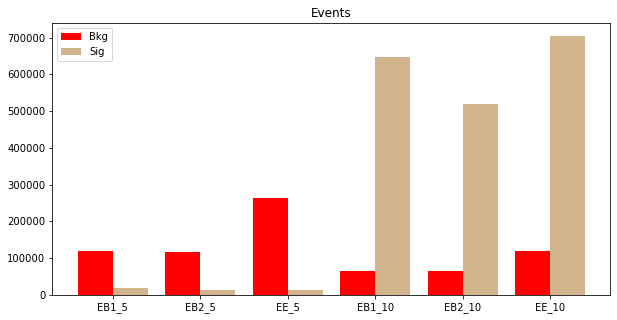

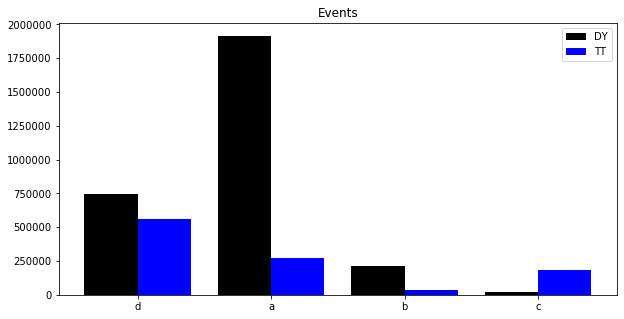

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Below are barrel features


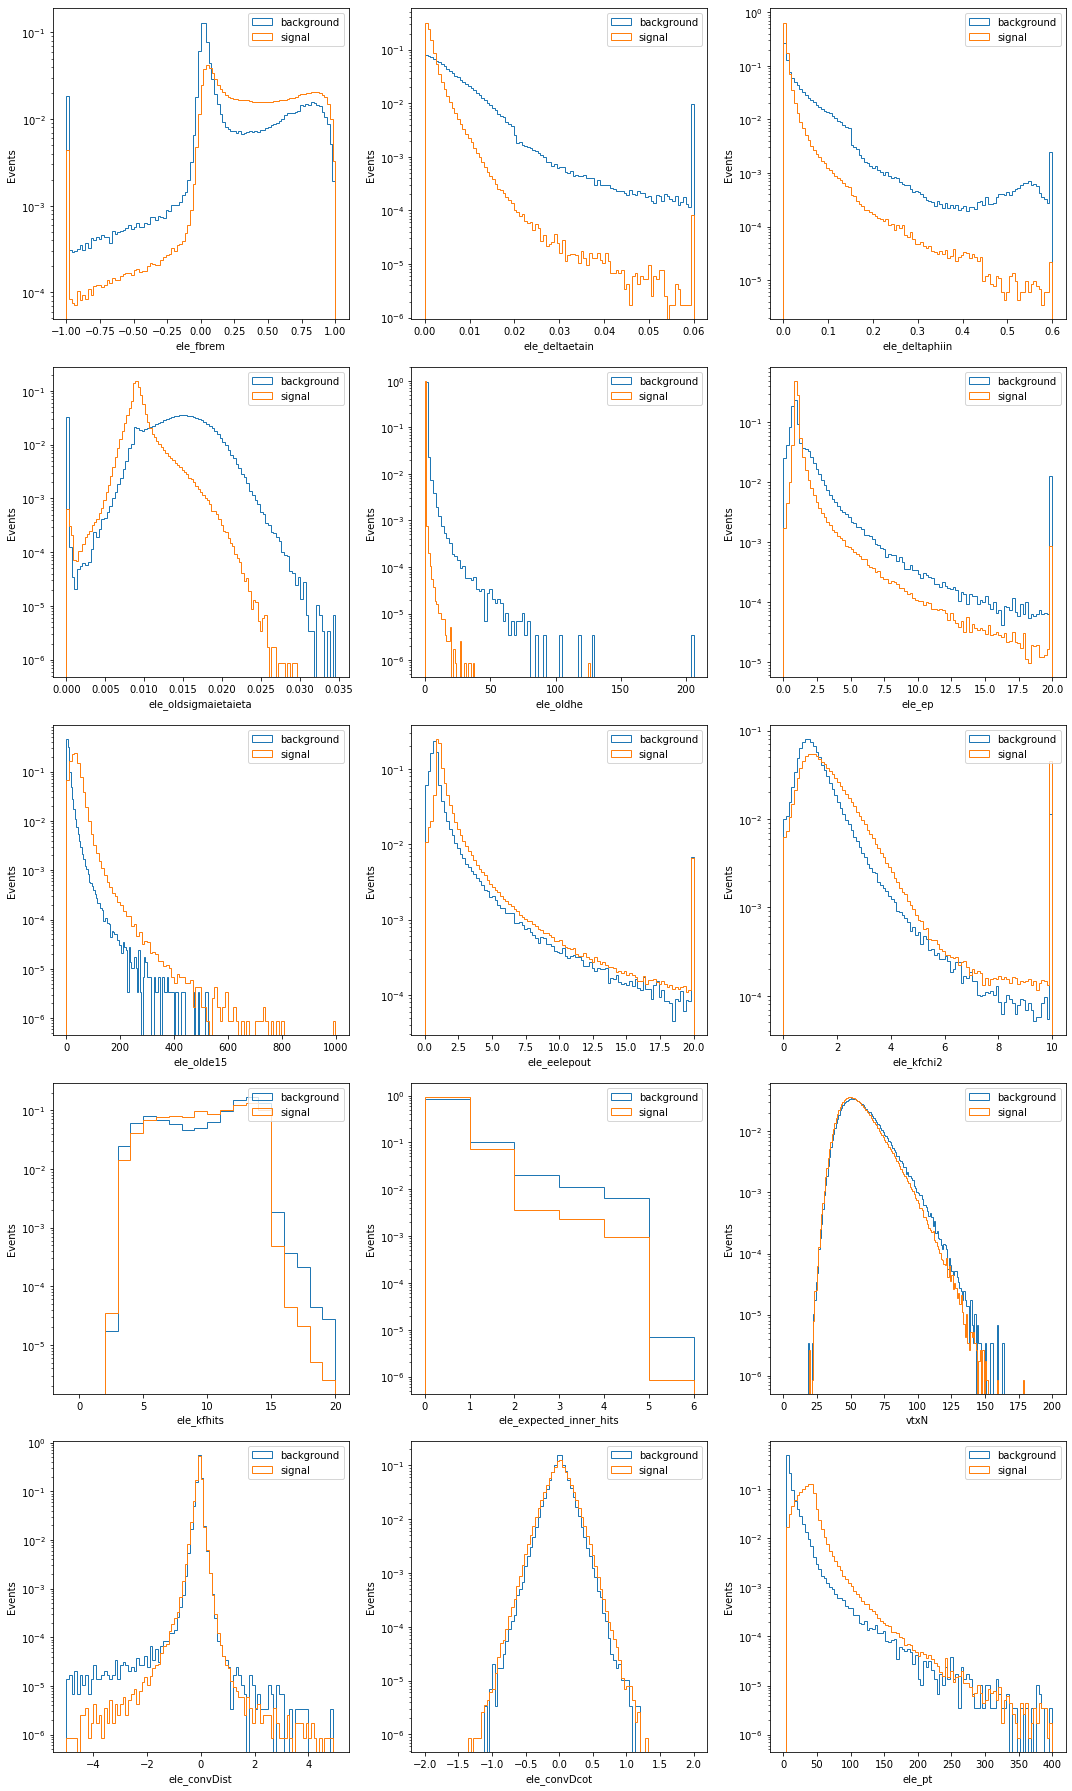

Below are endcap features


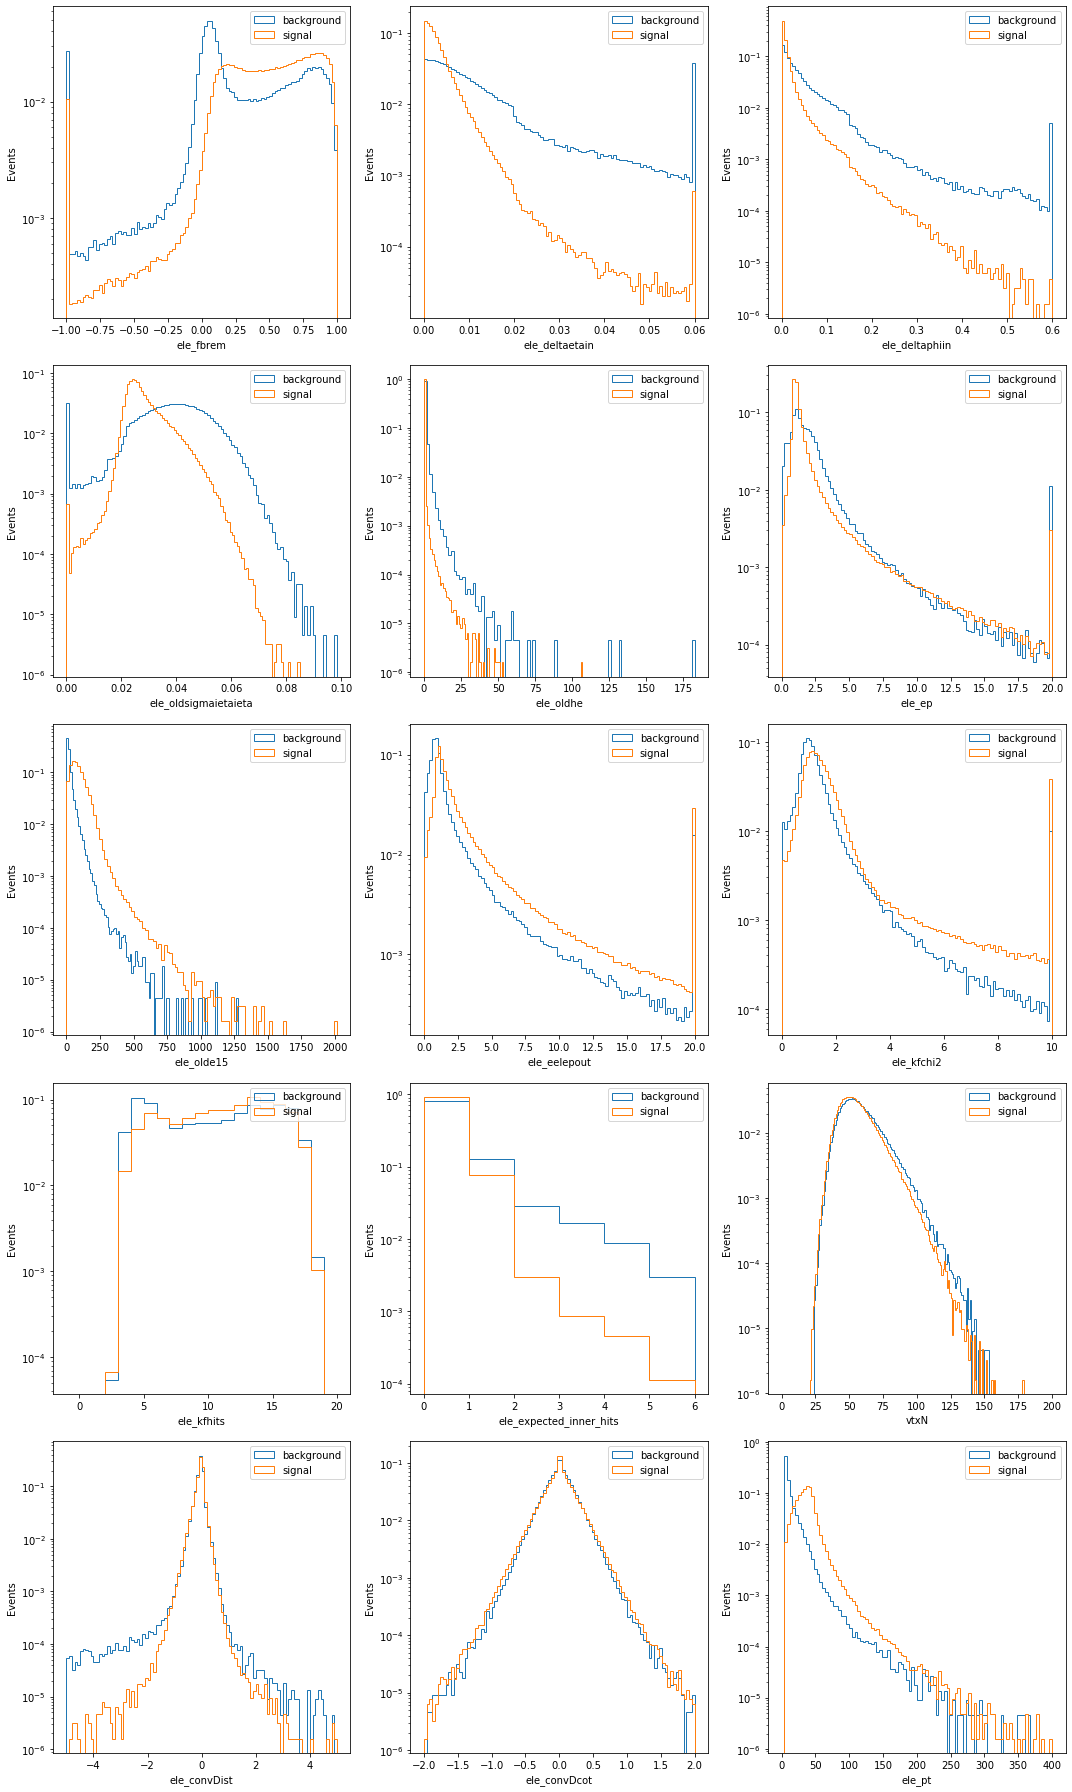

possum=21082
negsum=100061
poswt=4.7462764443601175


/usr/local/bin/start_ipykernel.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


EB1_5:
training XGB on 21082 signal and 100061 background electrons

possum=14403
negsum=81079
poswt=5.629313337499132
EB2_5:
training XGB on 14403 signal and 81079 background electrons

possum=13667
negsum=144379
poswt=10.564059413185044
EE_5:
training XGB on 13667 signal and 144379 background electrons

possum=639377
negsum=58821
negwt=10.869876404685401
EB1_10:
training XGB on 639377 signal and 58821 background electrons

possum=485007
negsum=51347
negwt=9.445673554443298
EB2_10:
training XGB on 485007 signal and 51347 background electrons

possum=617838
negsum=75980
negwt=8.131587259805212
EE_10:
training XGB on 617838 signal and 75980 background electrons



/usr/local/bin/start_ipykernel.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


possum=21082
negsum=100061
poswt=4.7462764443601175


W0810 10:59:33.574993 140061126260544 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


EB1_5:
training DNN on 21082 signal and 100061 background electrons


/usr/local/bin/start_ipykernel.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


possum=14403
negsum=81079
poswt=5.629313337499132
EB2_5:
training DNN on 14403 signal and 81079 background electrons


/usr/local/bin/start_ipykernel.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


possum=13667
negsum=144379
poswt=10.564059413185044
EE_5:
training DNN on 13667 signal and 144379 background electrons
Epoch 00170: early stopping


/usr/local/bin/start_ipykernel.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


possum=639377
negsum=58821
negwt=10.869876404685401
EB1_10:
training DNN on 639377 signal and 58821 background electrons


/usr/local/bin/start_ipykernel.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


possum=485007
negsum=51347
negwt=9.445673554443298
EB2_10:
training DNN on 485007 signal and 51347 background electrons
Epoch 00178: early stopping


/usr/local/bin/start_ipykernel.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


possum=617838
negsum=75980
negwt=8.131587259805212
EE_10:
training DNN on 617838 signal and 75980 background electrons


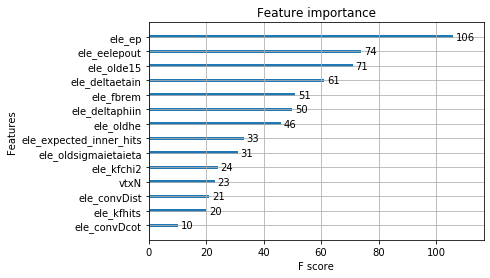

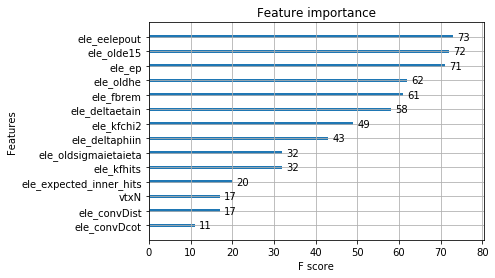

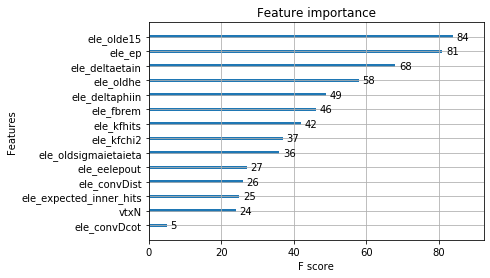

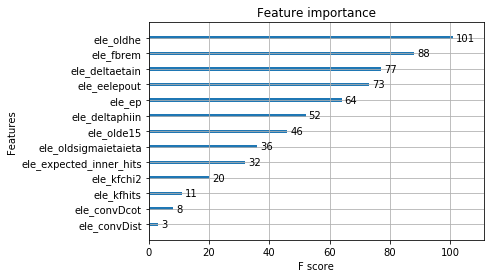

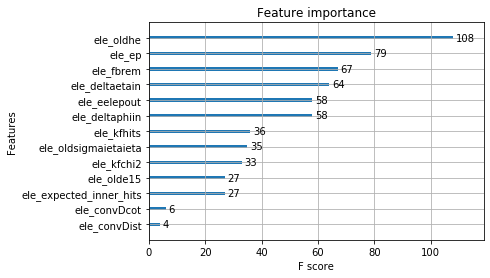

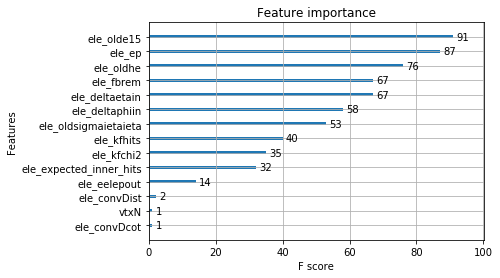

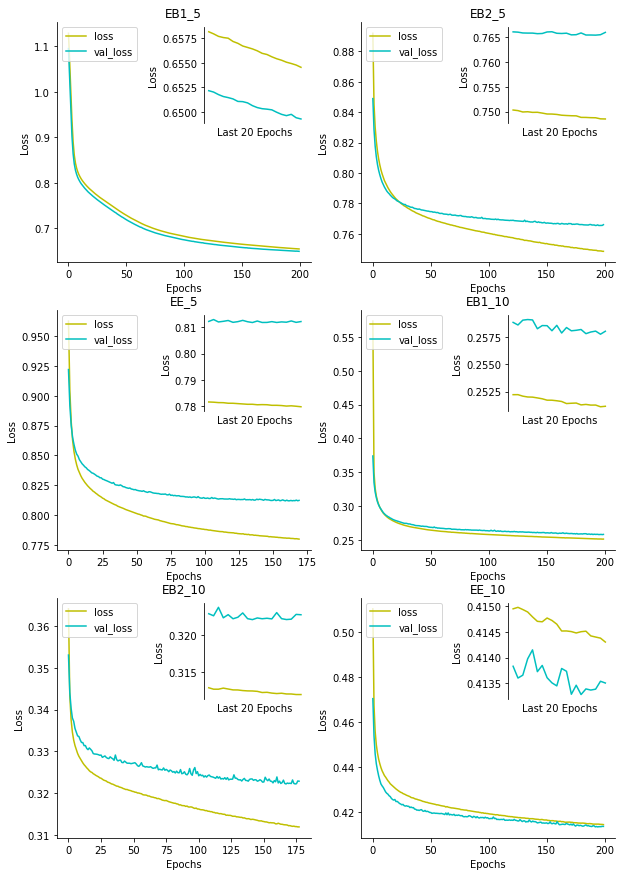

2020-08-10 10:59:34.212692: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-08-10 10:59:34.238059: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400115000 Hz
2020-08-10 10:59:34.239905: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2aa15990 executing computations on platform Host. Devices:
2020-08-10 10:59:34.239950: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2020-08-10 10:59:34.321832: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or s

In [9]:
df_DY = get_df(root_files, unneccesary_columns)
df_TT = get_df(root_files_TT, unneccesary_columns)

ShowEvents(df_DY)
ShowEventsdd(df_DY,df_TT,["DY","TT"])

df_DY = clean_df(df_DY)
df_TT = clean_df(df_TT)

dfcomb = pd.concat([df_DY, df_TT], ignore_index=True, sort=False)
df = df_DY

df_barrel = df.query("ele_isEB")
#ShowEvents(df)
df_endcap = df.query("ele_isEE")
#ShowEvents(df)

print("Below are barrel features")
plotfeatures(df_barrel)
print("Below are endcap features")
plotfeatures(df_endcap)

TrainXGB(df, catsplit, category_titles, features_endcap, features_barrel, xgboost_params)
train_history=TrainDNN(df, catsplit, category_titles, features_endcap, features_barrel, 
                       model, train_history,modelDNN,200,512)
plotloss(train_history, category_titles,catsplit)

0
EB1_5
-0.1
auc_mvanoniso=0.8495798328601567
1
EB2_5
-0.1
auc_mvanoniso=0.8173128229710794
2
EE_5
-0.1
auc_mvanoniso=0.7339707027935624
3
EB1_10
-0.1875
auc_mvaiso=0.9463100315516024
4
EB2_10
-0.1875
auc_mvaiso=0.9351873970504332
5
EE_10
-0.1075
auc_mvaiso=0.9194851866673789


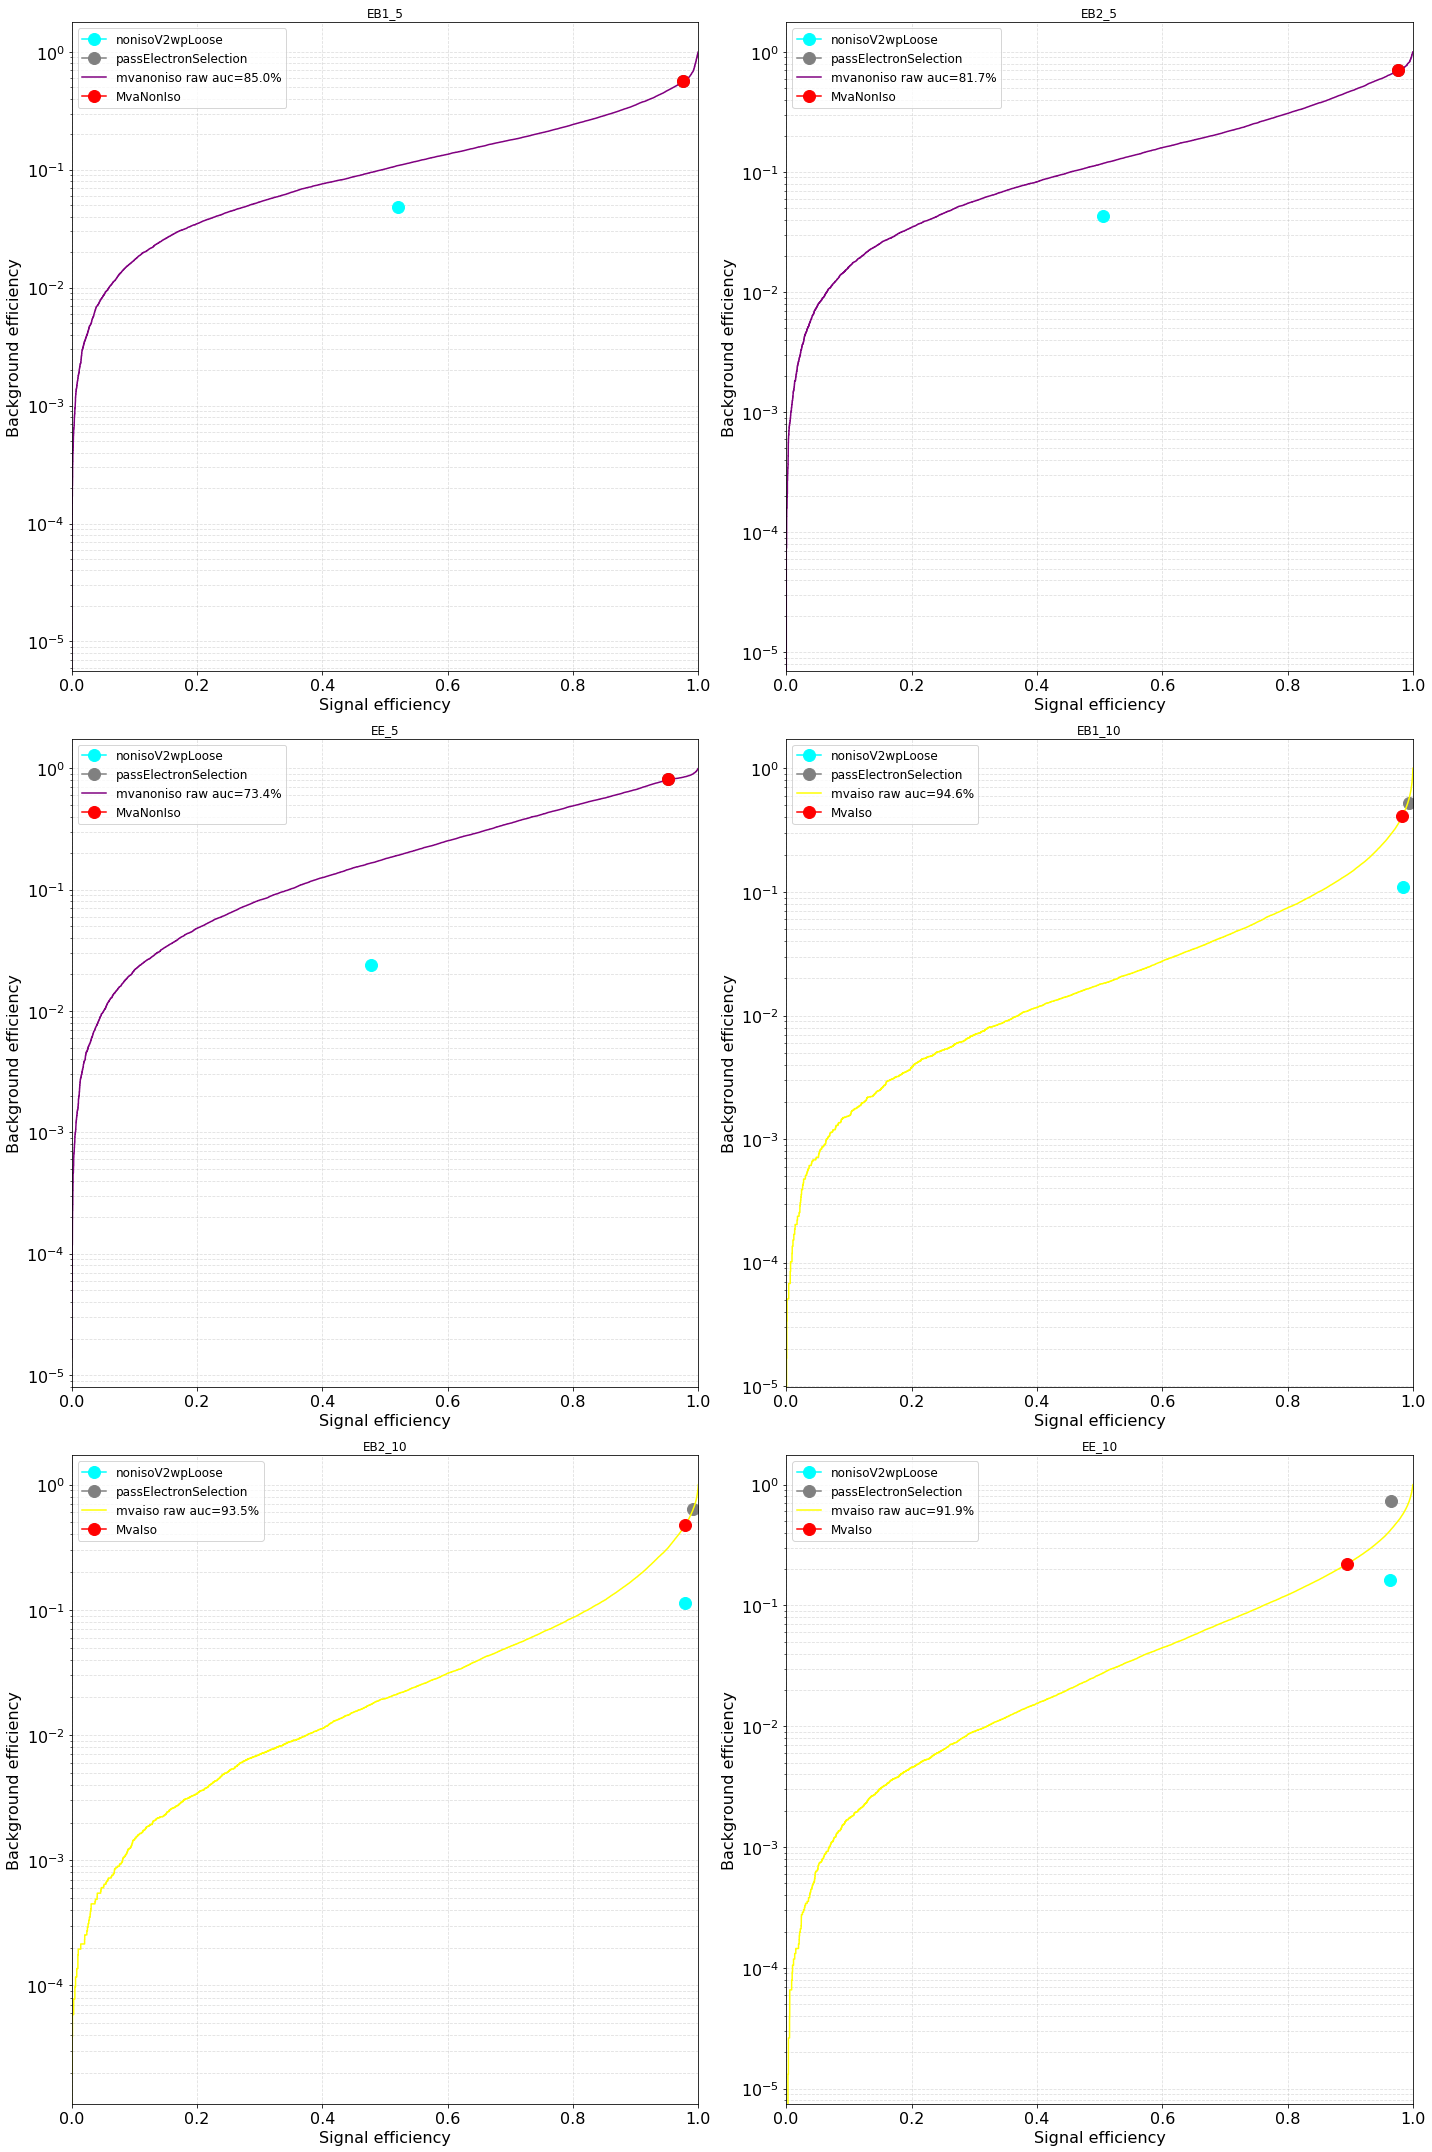

0
EB1_5
-0.1
auc_test=0.9045400706918506
auc_train=0.9147798520633683
auc_testDNN=0.9018754753005468
auc_trainDNN=0.9007365252804105
auc_mvanoniso=0.8495798328601567
1
EB2_5
-0.1
auc_test=0.8708852752978989
auc_train=0.8954095396723022
auc_testDNN=0.8703899905324602
auc_trainDNN=0.8763423311786319
auc_mvanoniso=0.8173128229710794
2
EE_5
-0.1
auc_test=0.8717102540567483
auc_train=0.8964249478593656
auc_testDNN=0.8770953392347363
auc_trainDNN=0.8846244953179694
auc_mvanoniso=0.7339707027935624
3
EB1_10
-0.1875
auc_test=0.9854974269803833
auc_train=0.9871576217972875
auc_testDNN=0.9874051266671902
auc_trainDNN=0.9881467127956264
auc_mvaiso=0.9463100315516024
4
EB2_10
-0.1875
auc_test=0.9767846859223386
auc_train=0.9789005645821639
auc_testDNN=0.9804442764568434
auc_trainDNN=0.9814937130363838
auc_mvaiso=0.9351873970504332
5
EE_10
-0.1075
auc_test=0.961589323004947
auc_train=0.9626084275543658
auc_testDNN=0.9669642431572343
auc_trainDNN=0.9668193388407044
auc_mvaiso=0.9194851866673789


/usr/local/bin/start_ipykernel.py:90: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


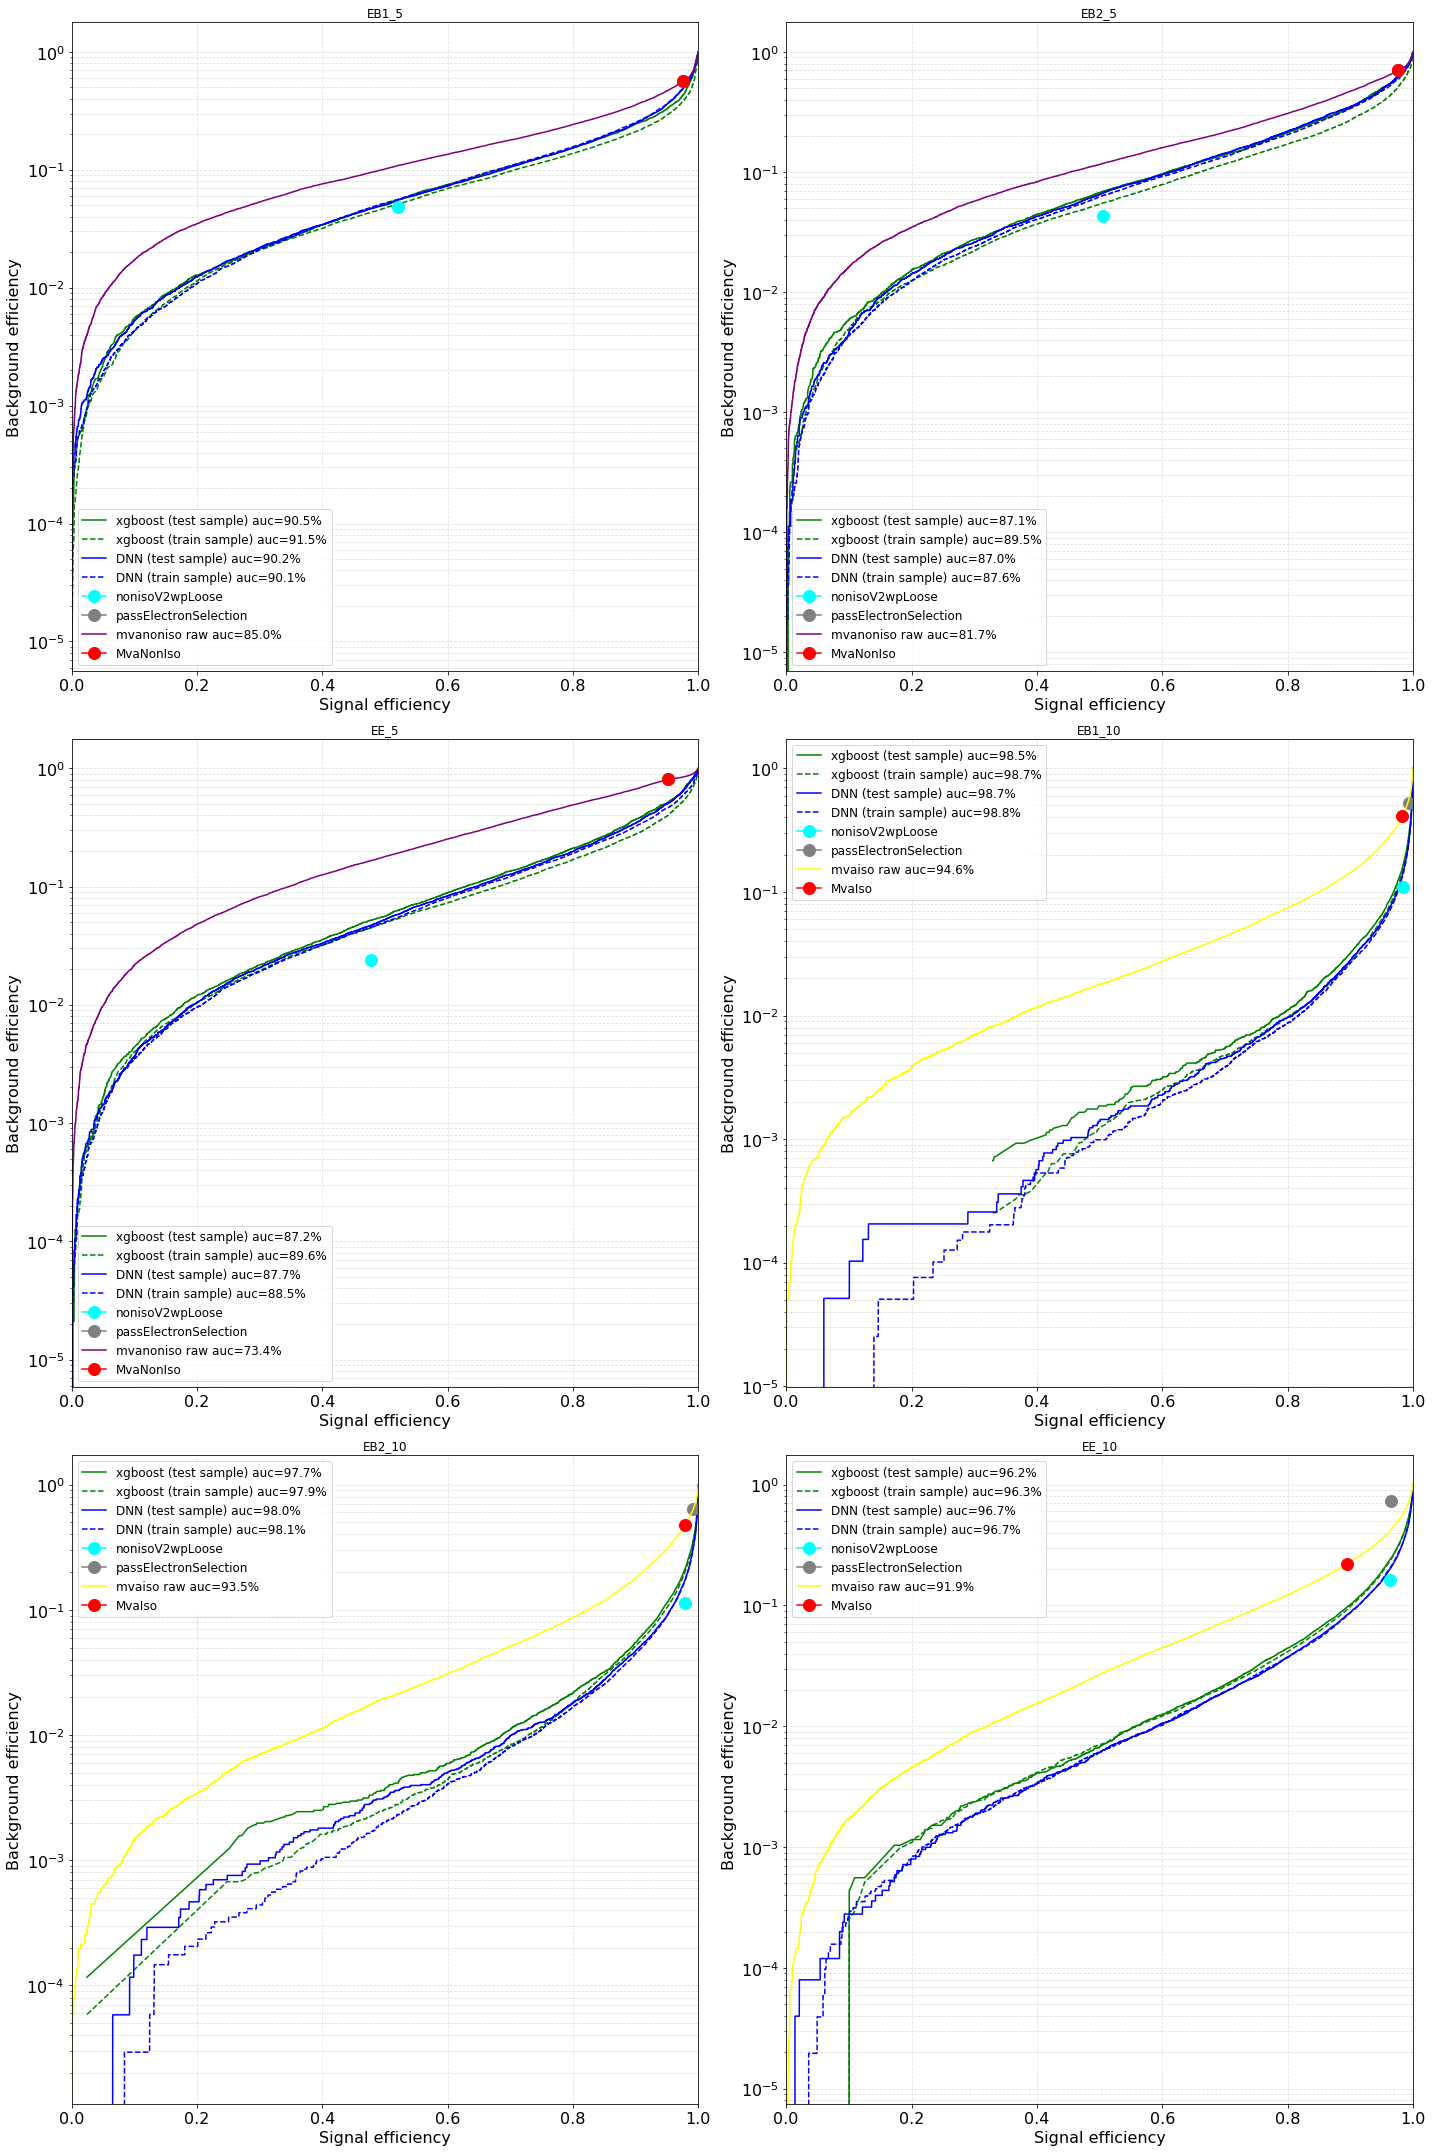

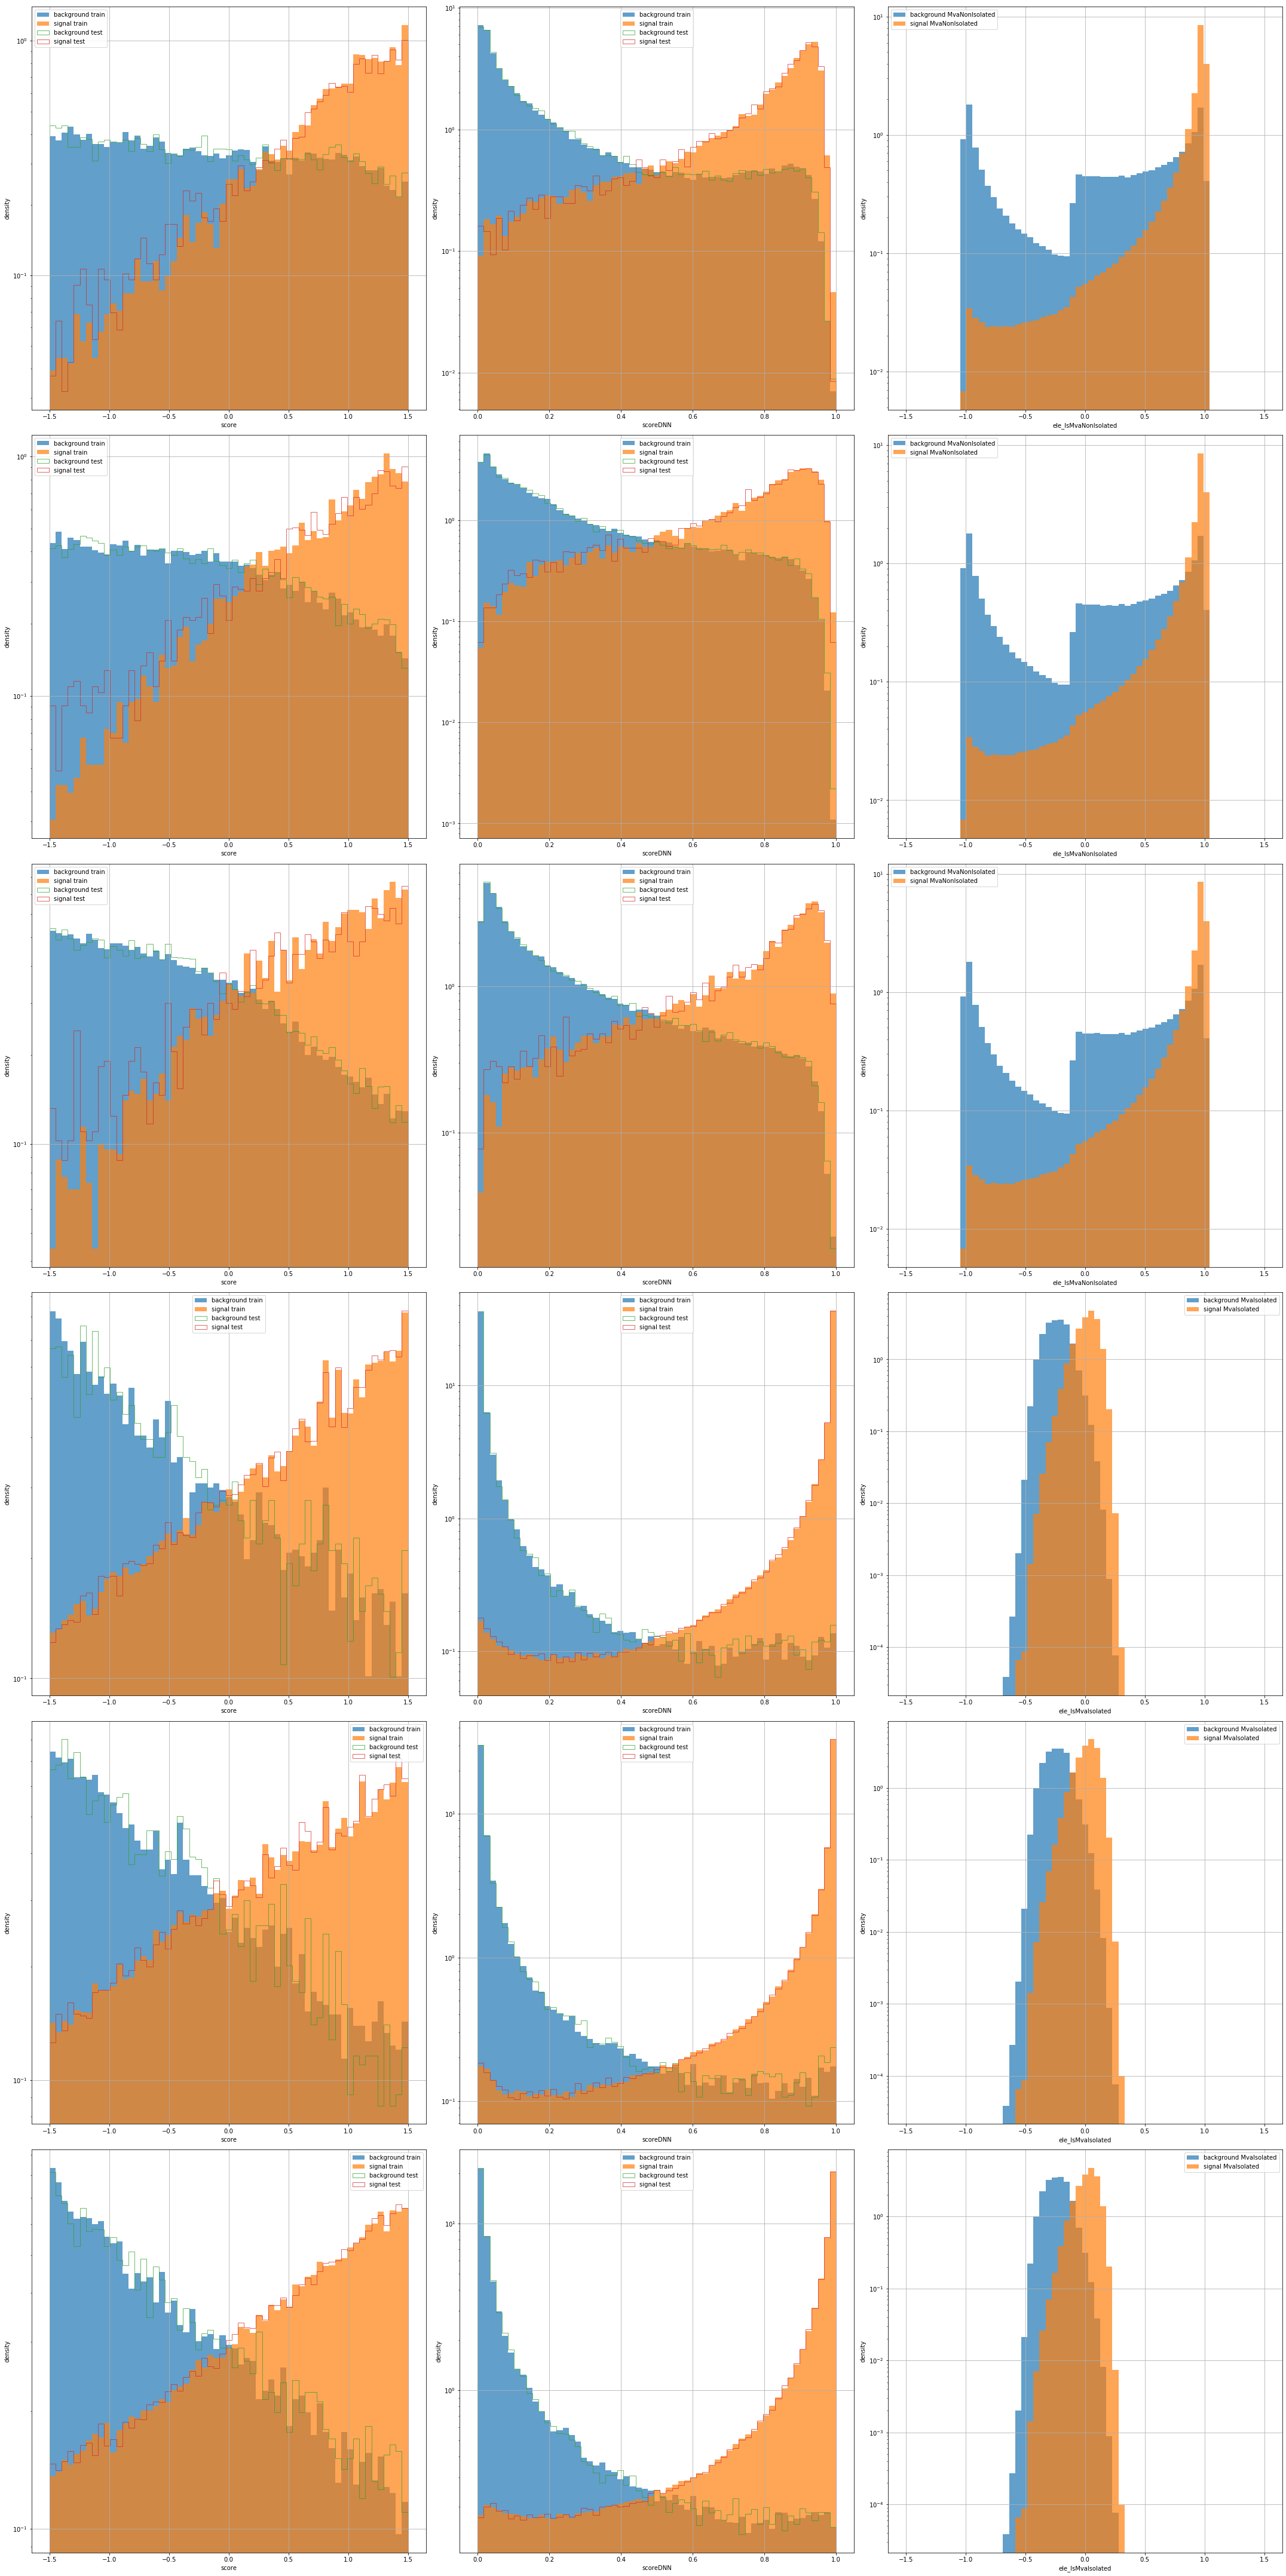

In [10]:
plot_FinalROCsandMVAs(df,catsplit,"WP","ROC")
plot_FinalROCsandMVAs(df,catsplit)

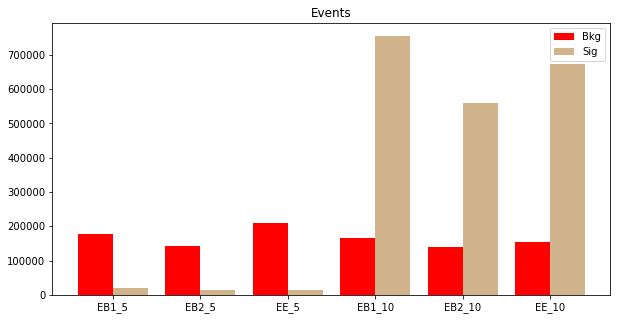

possum=55504
negsum=176510
poswt=3.1801311617180743


/usr/local/bin/start_ipykernel.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


EB1_5:
training XGB on 55504 signal and 176510 background electrons

possum=32828
negsum=141885
poswt=4.3220726209333495
EB2_5:
training XGB on 32828 signal and 141885 background electrons

possum=23991
negsum=208511
poswt=8.6912175399108
EE_5:
training XGB on 23991 signal and 208511 background electrons

possum=820506
negsum=166573
negwt=4.925804302017734
EB1_10:
training XGB on 820506 signal and 166573 background electrons

possum=596931
negsum=138854
negwt=4.298983104555864
EB2_10:
training XGB on 596931 signal and 138854 background electrons

possum=699500
negsum=153916
negwt=4.544686712232647
EE_10:
training XGB on 699500 signal and 153916 background electrons



/usr/local/bin/start_ipykernel.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


possum=55504
negsum=176510
poswt=3.1801311617180743
EB1_5:
training DNN on 55504 signal and 176510 background electrons


/usr/local/bin/start_ipykernel.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


possum=32828
negsum=141885
poswt=4.3220726209333495


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


EB2_5:
training DNN on 32828 signal and 141885 background electrons


/usr/local/bin/start_ipykernel.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


possum=23991
negsum=208511
poswt=8.6912175399108
EE_5:
training DNN on 23991 signal and 208511 background electrons
Epoch 00138: early stopping


/usr/local/bin/start_ipykernel.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


possum=820506
negsum=166573
negwt=4.925804302017734
EB1_10:
training DNN on 820506 signal and 166573 background electrons
Epoch 00184: early stopping


/usr/local/bin/start_ipykernel.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


possum=596931
negsum=138854
negwt=4.298983104555864
EB2_10:
training DNN on 596931 signal and 138854 background electrons
Epoch 00070: early stopping


/usr/local/bin/start_ipykernel.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


possum=699500
negsum=153916
negwt=4.544686712232647
EE_10:
training DNN on 699500 signal and 153916 background electrons
Epoch 00137: early stopping


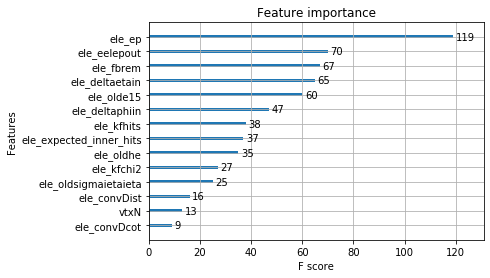

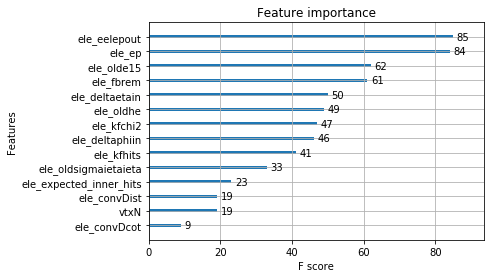

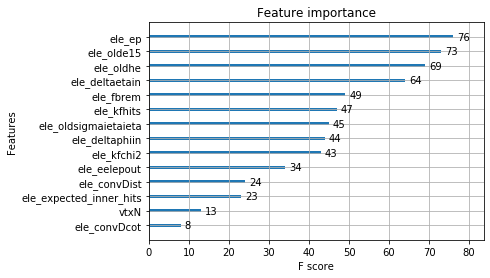

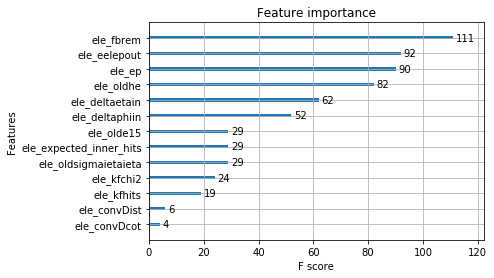

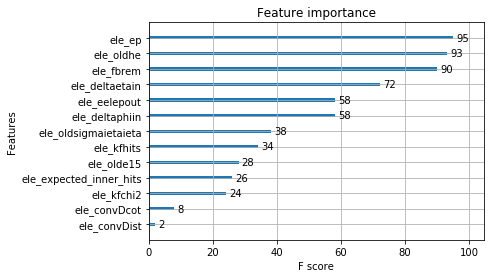

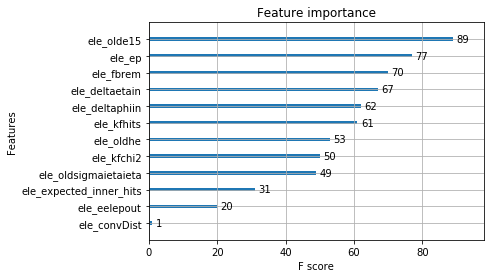

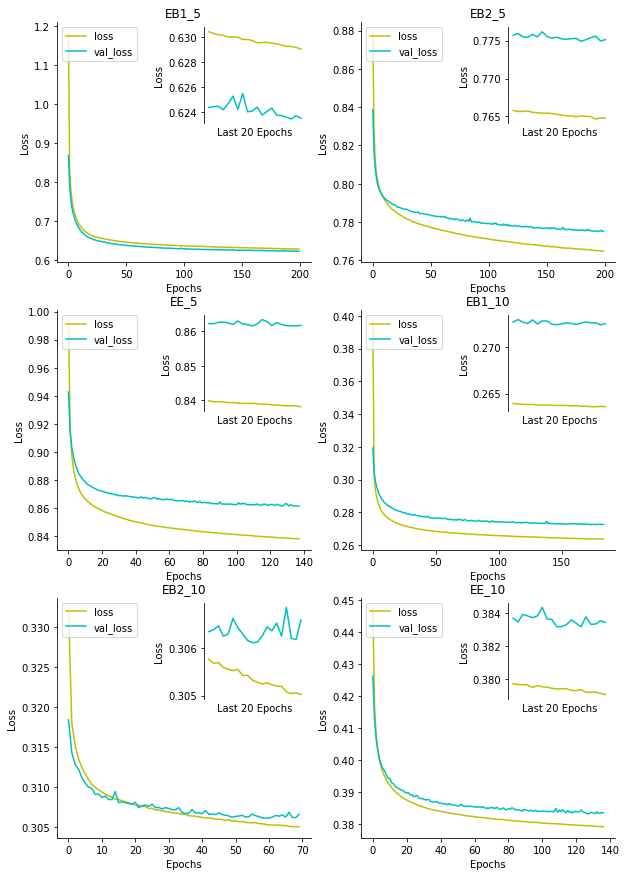

In [11]:
ShowEvents(dfcomb)

TrainXGB(dfcomb, catsplit, category_titles, features_endcap, features_barrel, xgboost_params)
train_history=TrainDNN(dfcomb, catsplit, category_titles, features_endcap, features_barrel, 
                       model, train_history,modelDNN,200,512)
plotloss(train_history, category_titles,catsplit)

0
EB1_5
-0.1
auc_test=0.8908721986252817
auc_train=0.8945853189762885
auc_testDNN=0.8927893716426568
auc_trainDNN=0.8920012695285185
auc_mvanoniso=0.8372473564141253
1
EB2_5
-0.1
auc_test=0.8444233092510507
auc_train=0.8598380793009086
auc_testDNN=0.8533903898221068
auc_trainDNN=0.8576144254531725
auc_mvanoniso=0.8011379666607381
2
EE_5
-0.1
auc_test=0.8460450141624284
auc_train=0.8650927311353849
auc_testDNN=0.8533580005364995
auc_trainDNN=0.8592924327674895
auc_mvanoniso=0.7308394525320372
3
EB1_10
-0.1875
auc_test=0.9782408163485433
auc_train=0.9797493227052546
auc_testDNN=0.981684209658835
auc_trainDNN=0.9826506269147106
auc_mvaiso=0.9486026844631856
4
EB2_10
-0.1875
auc_test=0.97098087960742
auc_train=0.9718262083176062
auc_testDNN=0.9760476465403829
auc_trainDNN=0.9761032723634212
auc_mvaiso=0.9382697856421244
5
EE_10
-0.1075
auc_test=0.9590720519216123
auc_train=0.9607641265013999
auc_testDNN=0.9654648382457545
auc_trainDNN=0.9663157147862655
auc_mvaiso=0.928040816025993


/usr/local/bin/start_ipykernel.py:90: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


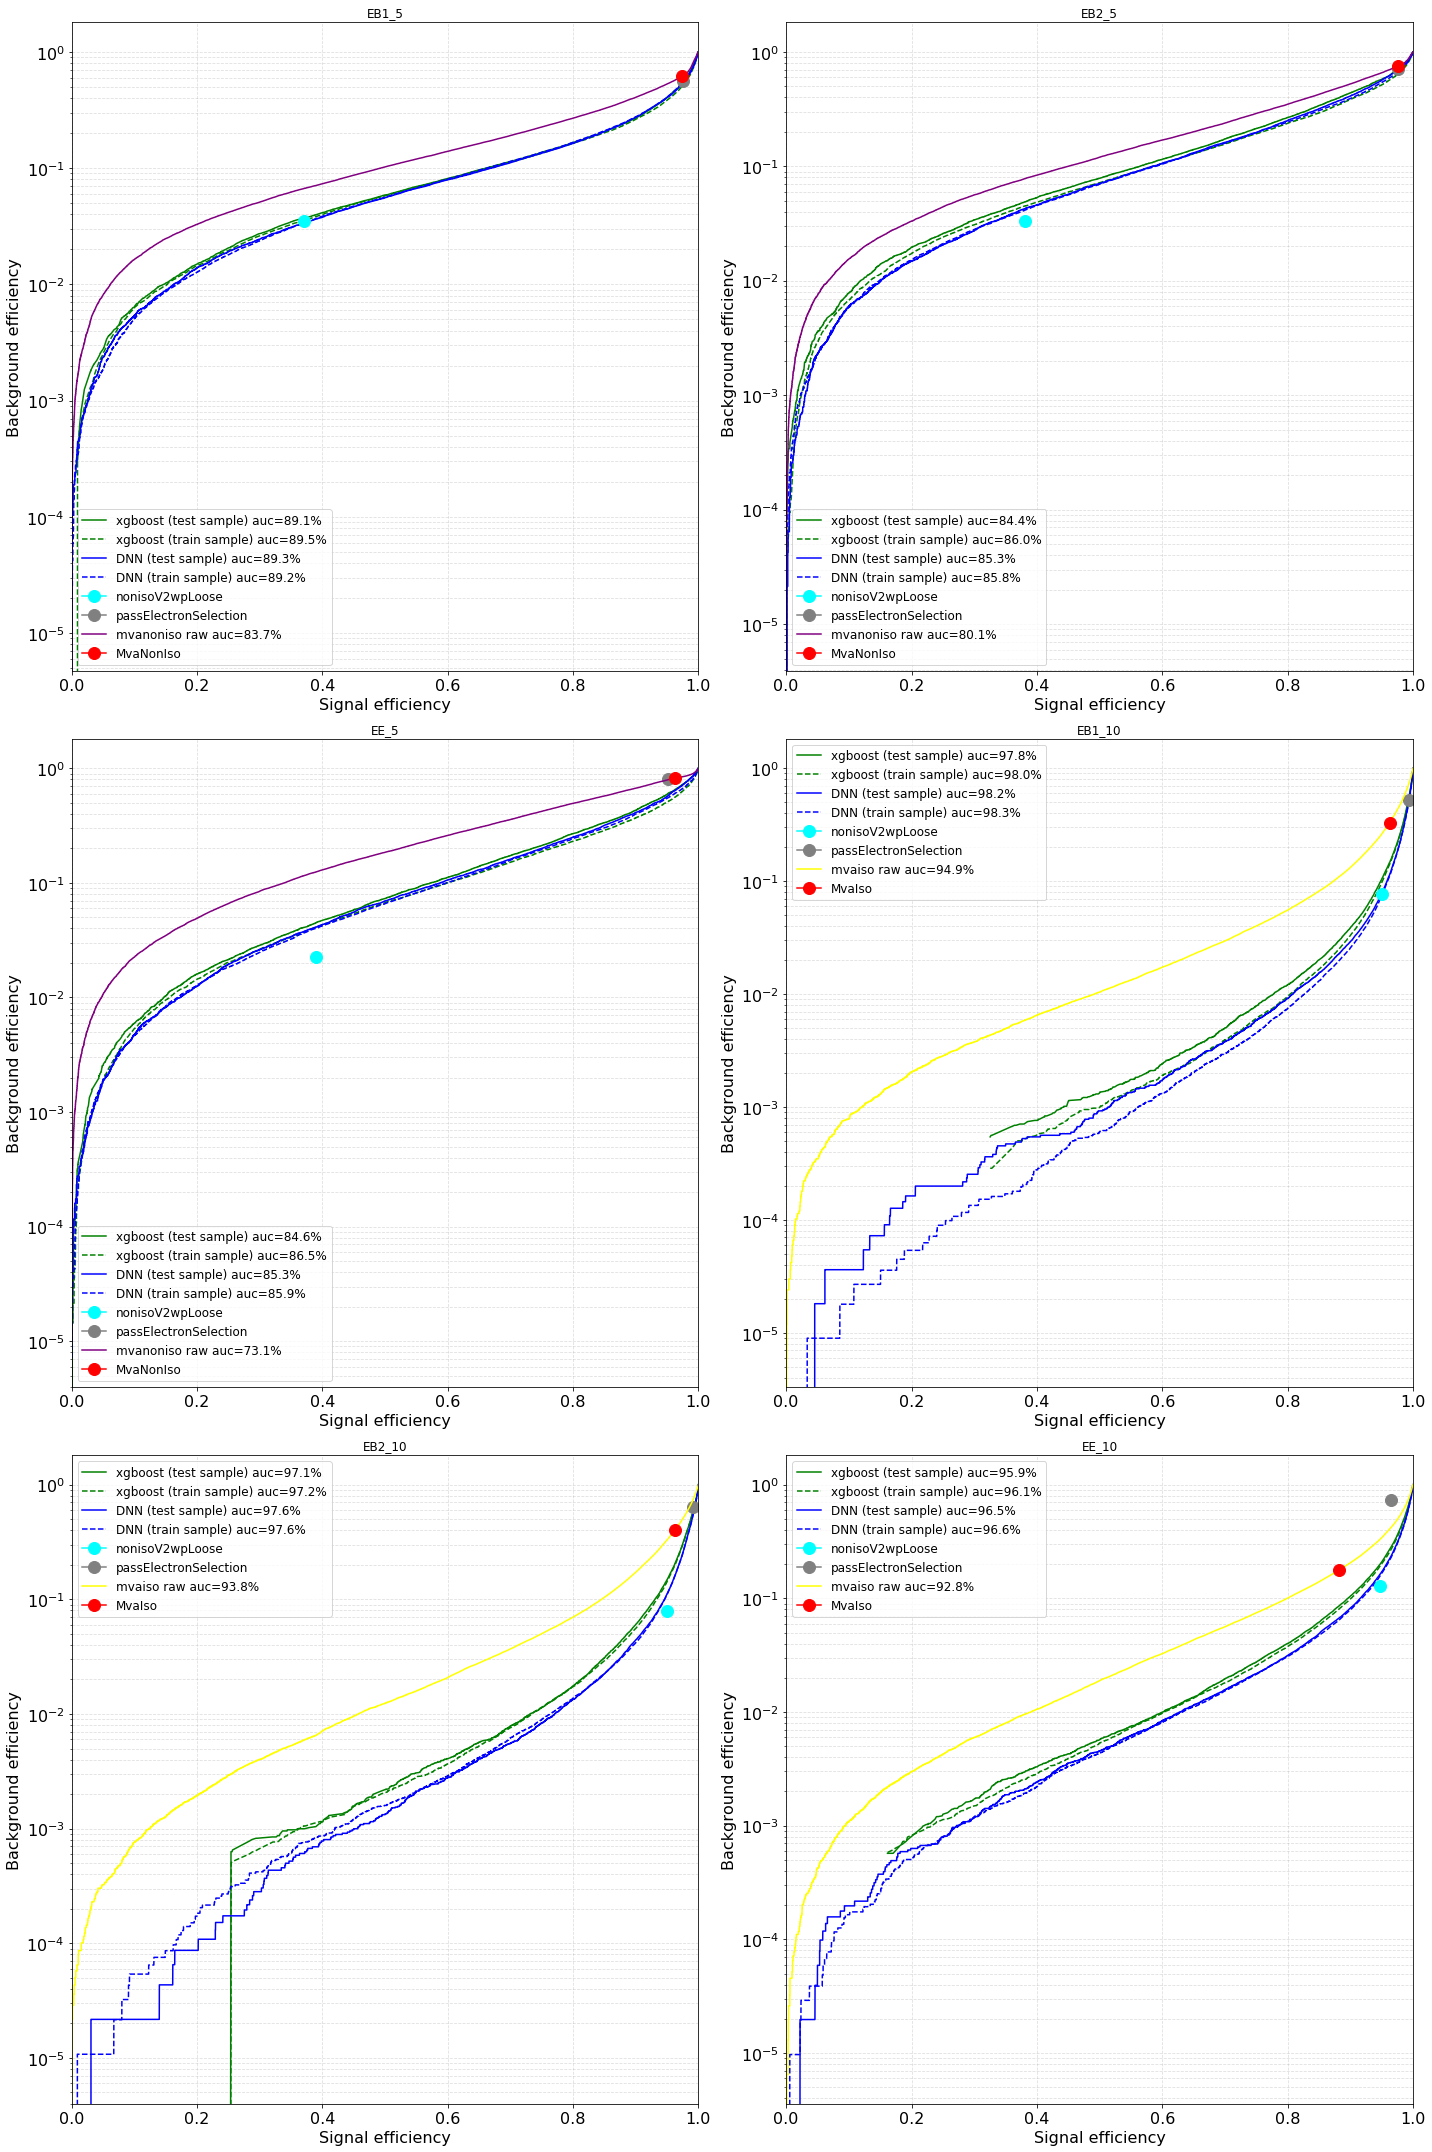

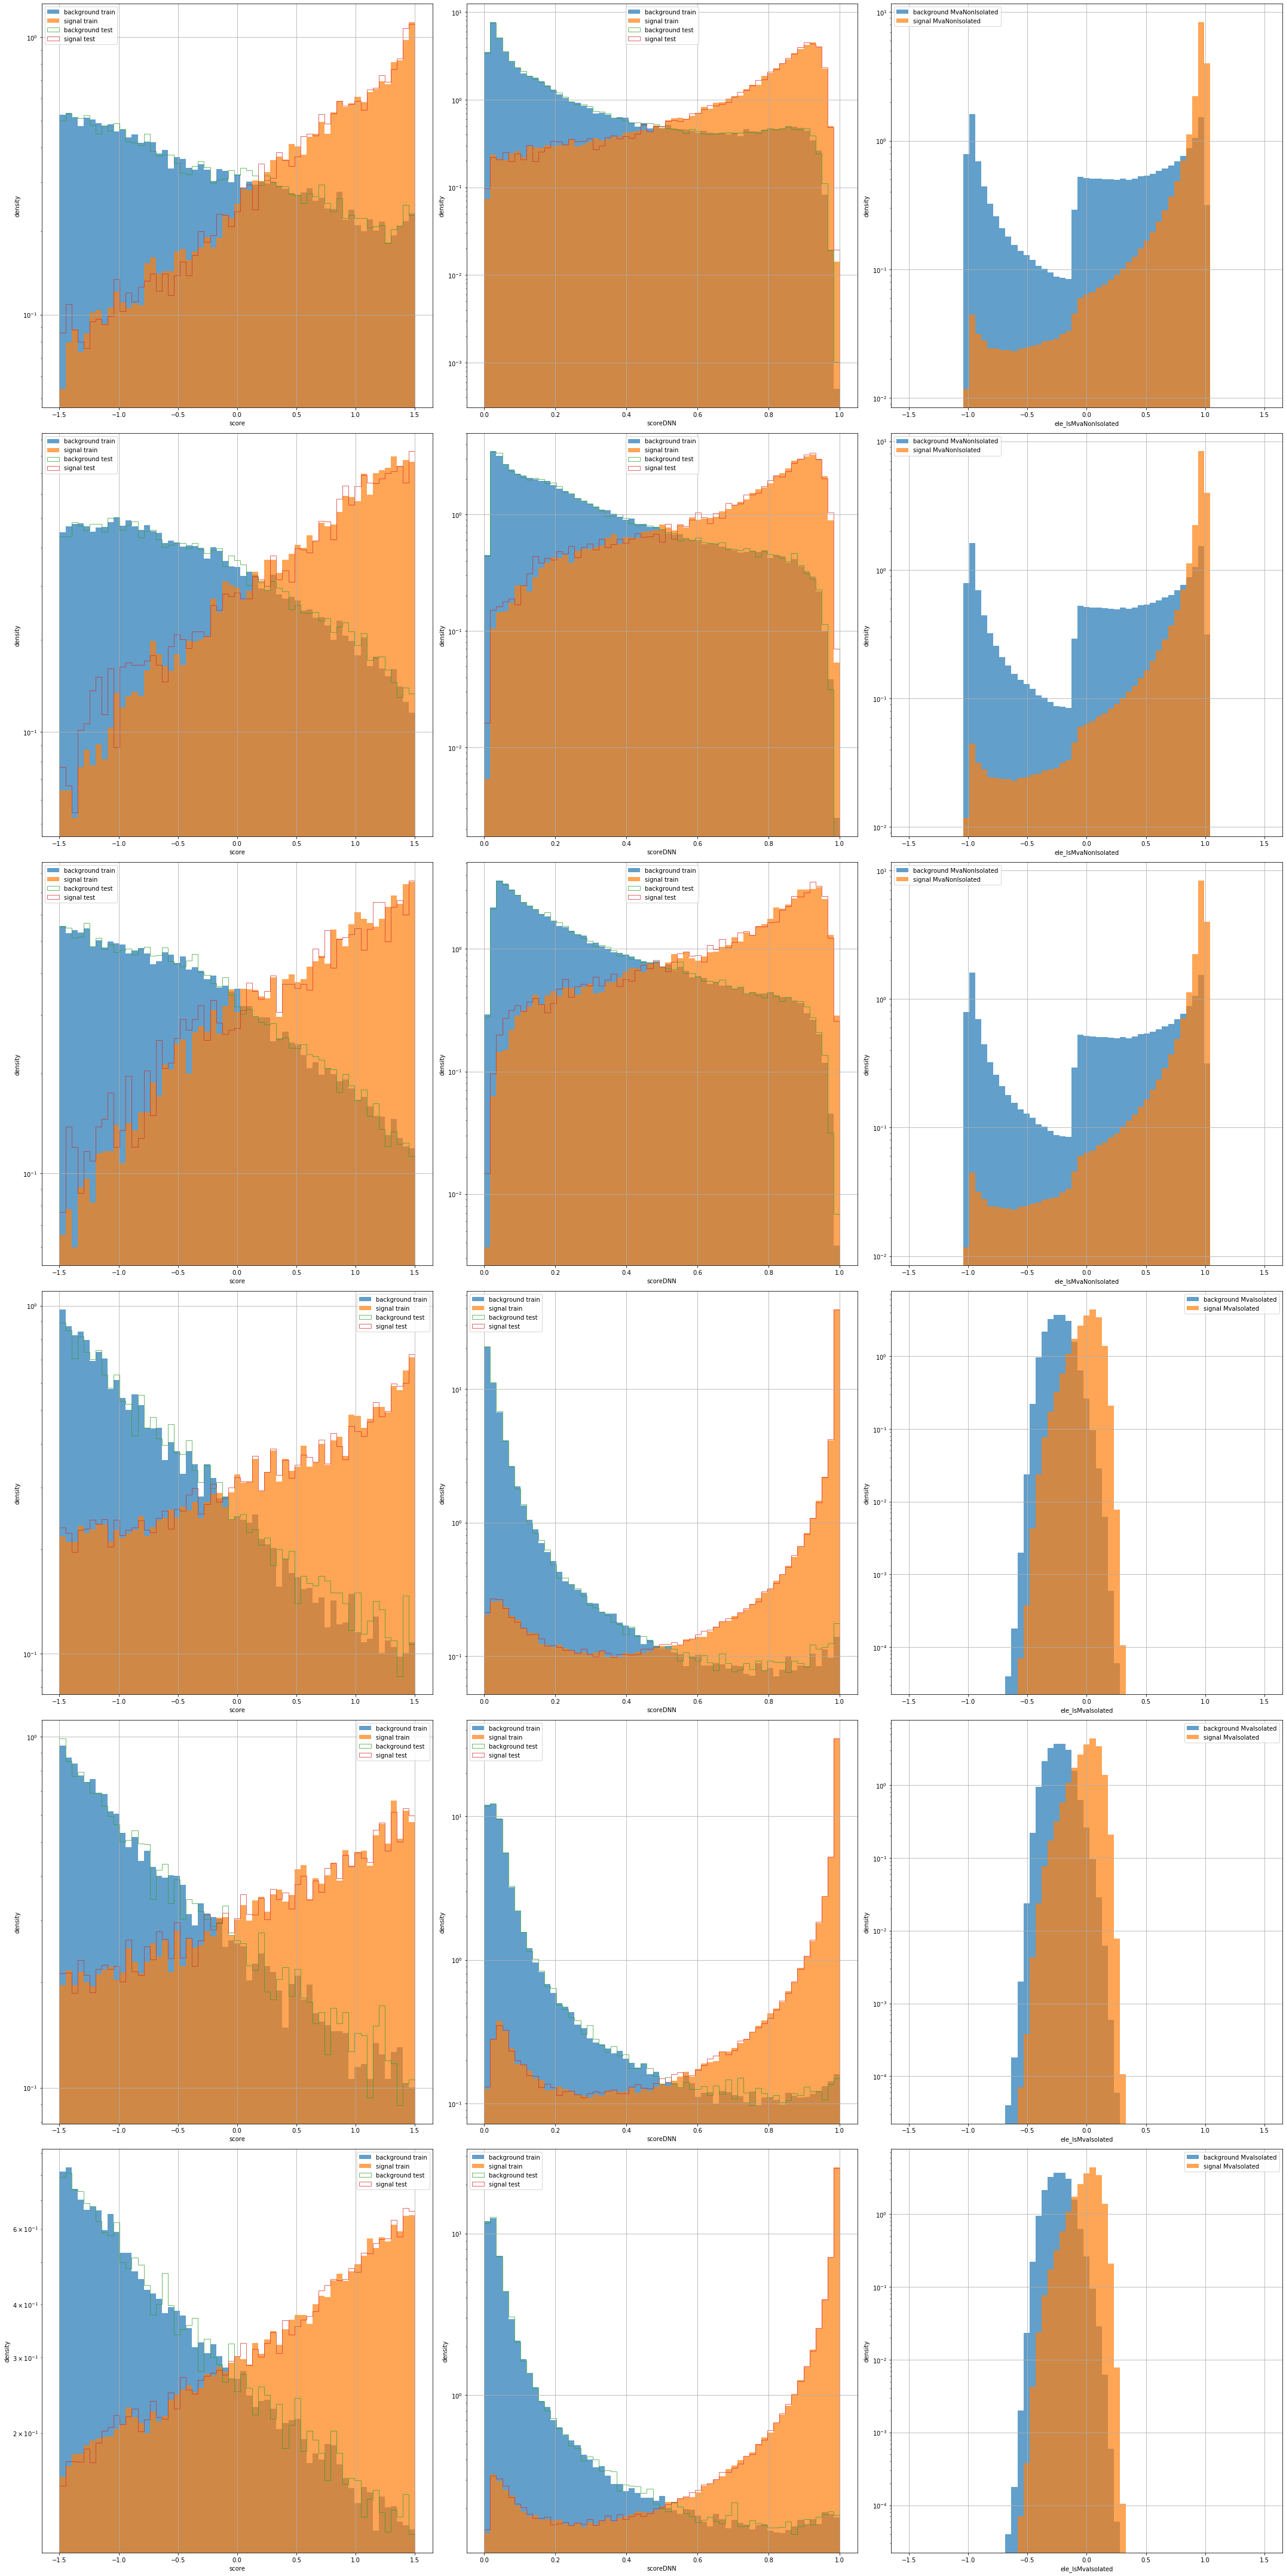

In [12]:
plot_FinalROCsandMVAs(dfcomb,catsplit)

0
EB1_5
-0.1
auc_test=0.876371882621454
auc_train=0.8793483205214395
auc_testDNN=0.8767214734084912
auc_trainDNN=0.8752666159174234
auc_mvanoniso=0.8241562176841999
1
EB2_5
-0.1
auc_test=0.8128242391784652
auc_train=0.8308087580964763
auc_testDNN=0.822801318289492
auc_trainDNN=0.8270478077151651
auc_mvanoniso=0.7847327746765176
2
EE_5
-0.1
auc_test=0.7963104149274555
auc_train=0.8208631921769848
auc_testDNN=0.8064003115270487
auc_trainDNN=0.8130433646793748
auc_mvanoniso=0.7193944141889932
3
EB1_10
-0.1875
auc_test=0.8471158577714681
auc_train=0.852200555069899
auc_testDNN=0.8657099843348168
auc_trainDNN=0.8681367317083434
auc_mvaiso=0.7581570022733102
4
EB2_10
-0.1875
auc_test=0.7749903088182117
auc_train=0.7802203852743876
auc_testDNN=0.8055675687049001
auc_trainDNN=0.8081646588302732
auc_mvaiso=0.715443126369983
5
EE_10
-0.1075
auc_test=0.6861305927194026
auc_train=0.6953586333159065
auc_testDNN=0.7238404350291768
auc_trainDNN=0.731094932017222
auc_mvaiso=0.7046779812412262


/usr/local/bin/start_ipykernel.py:90: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


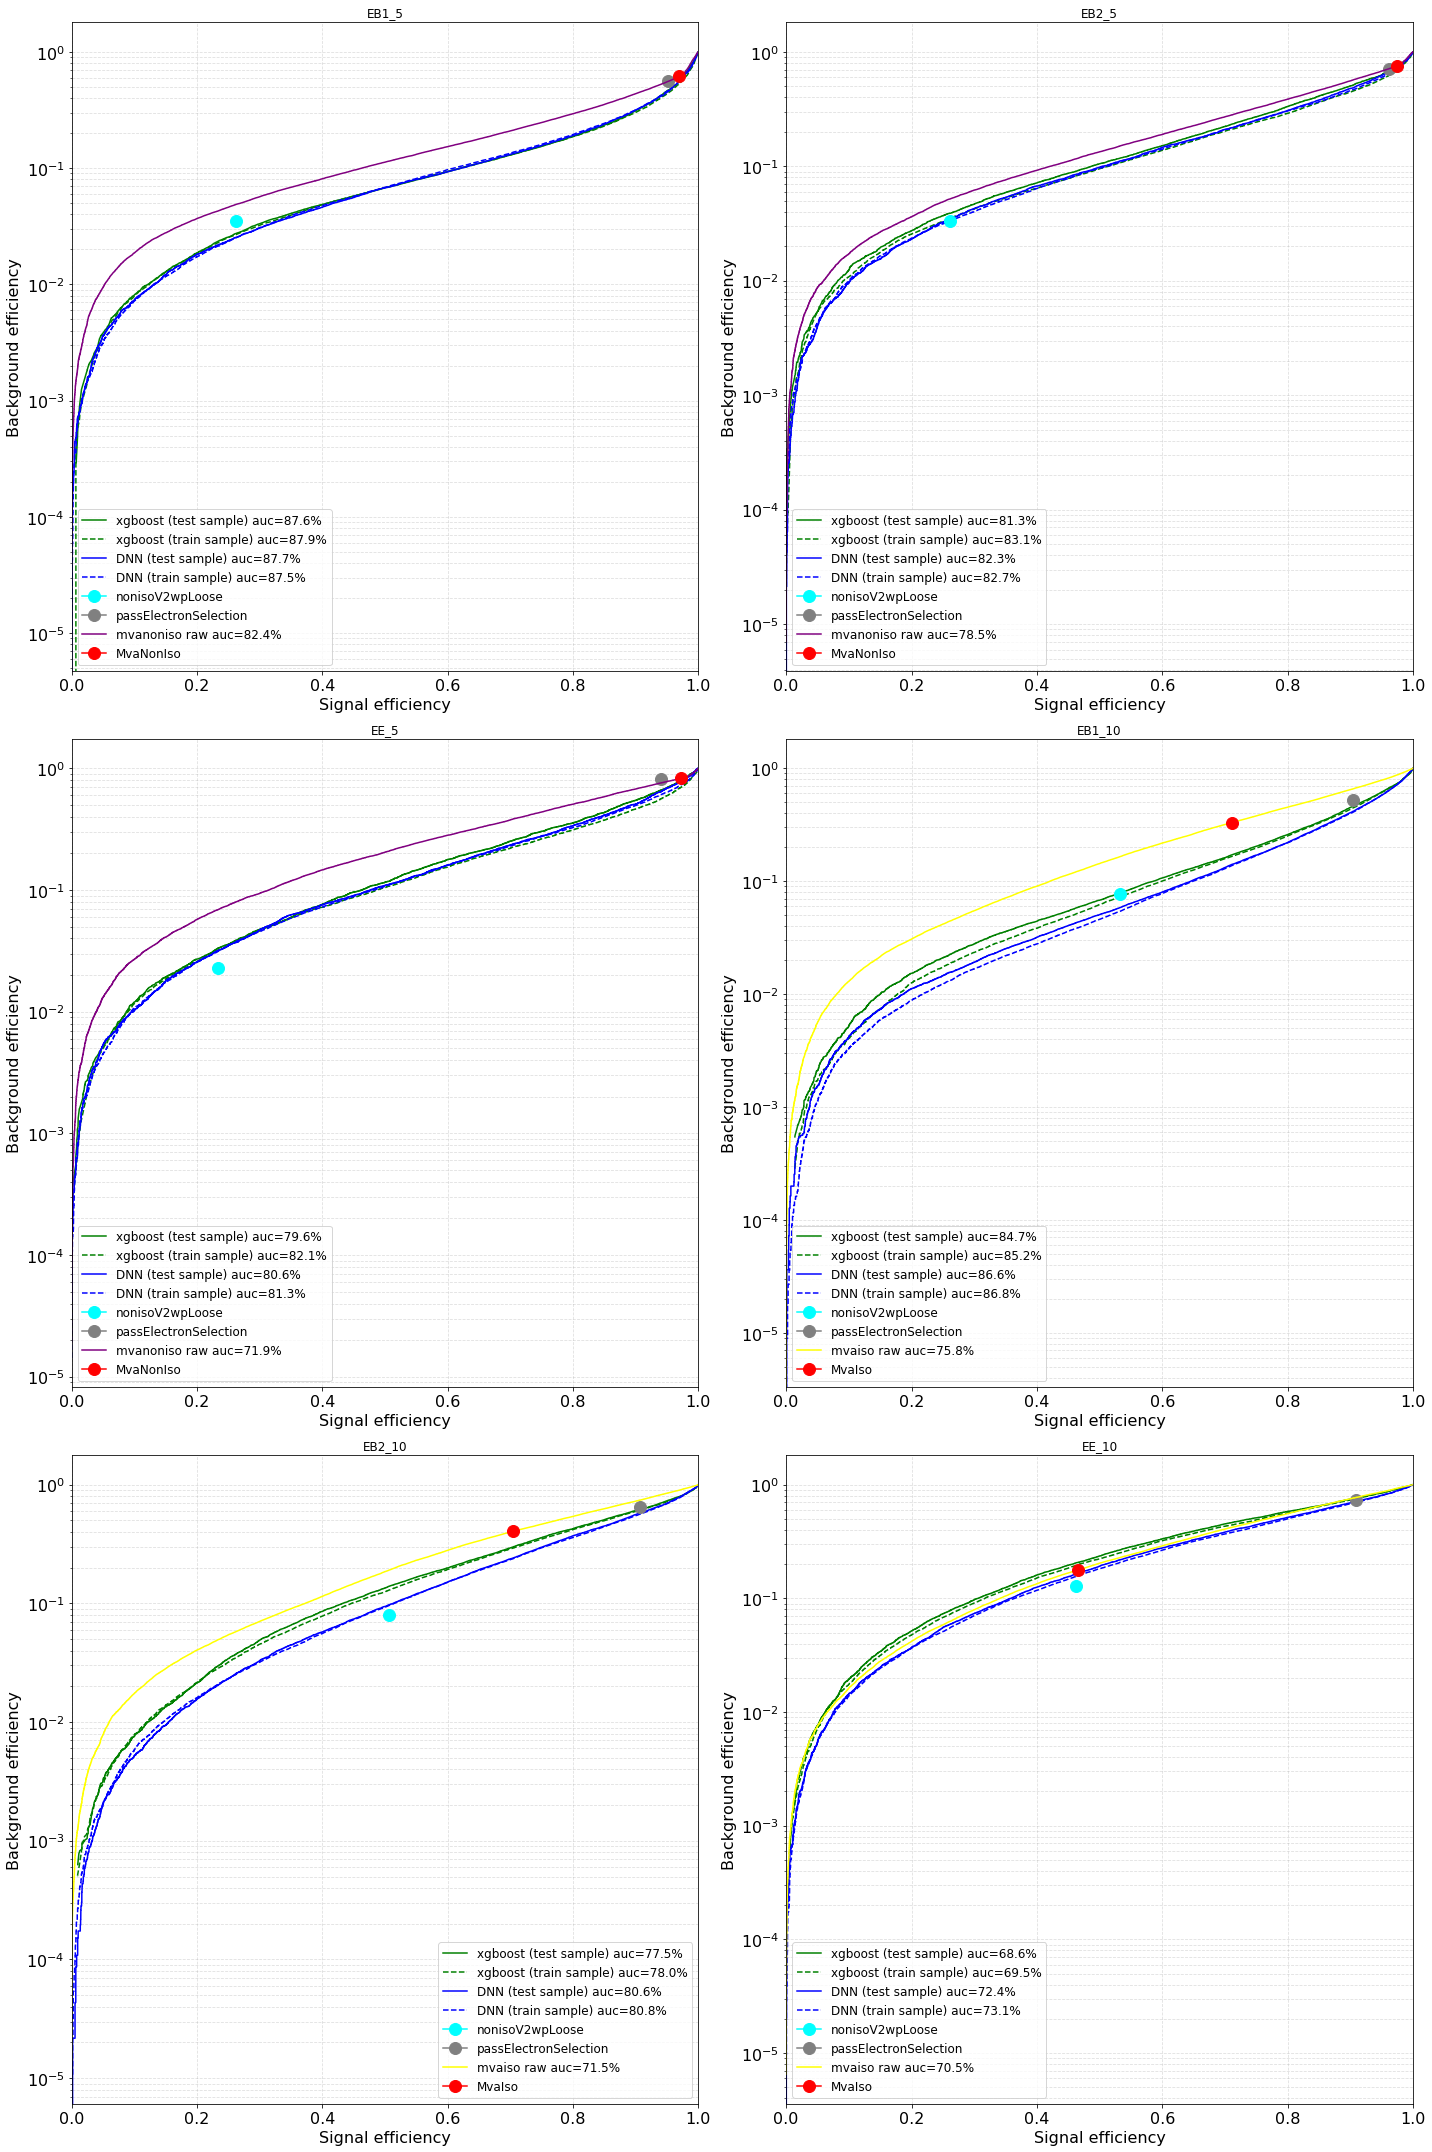

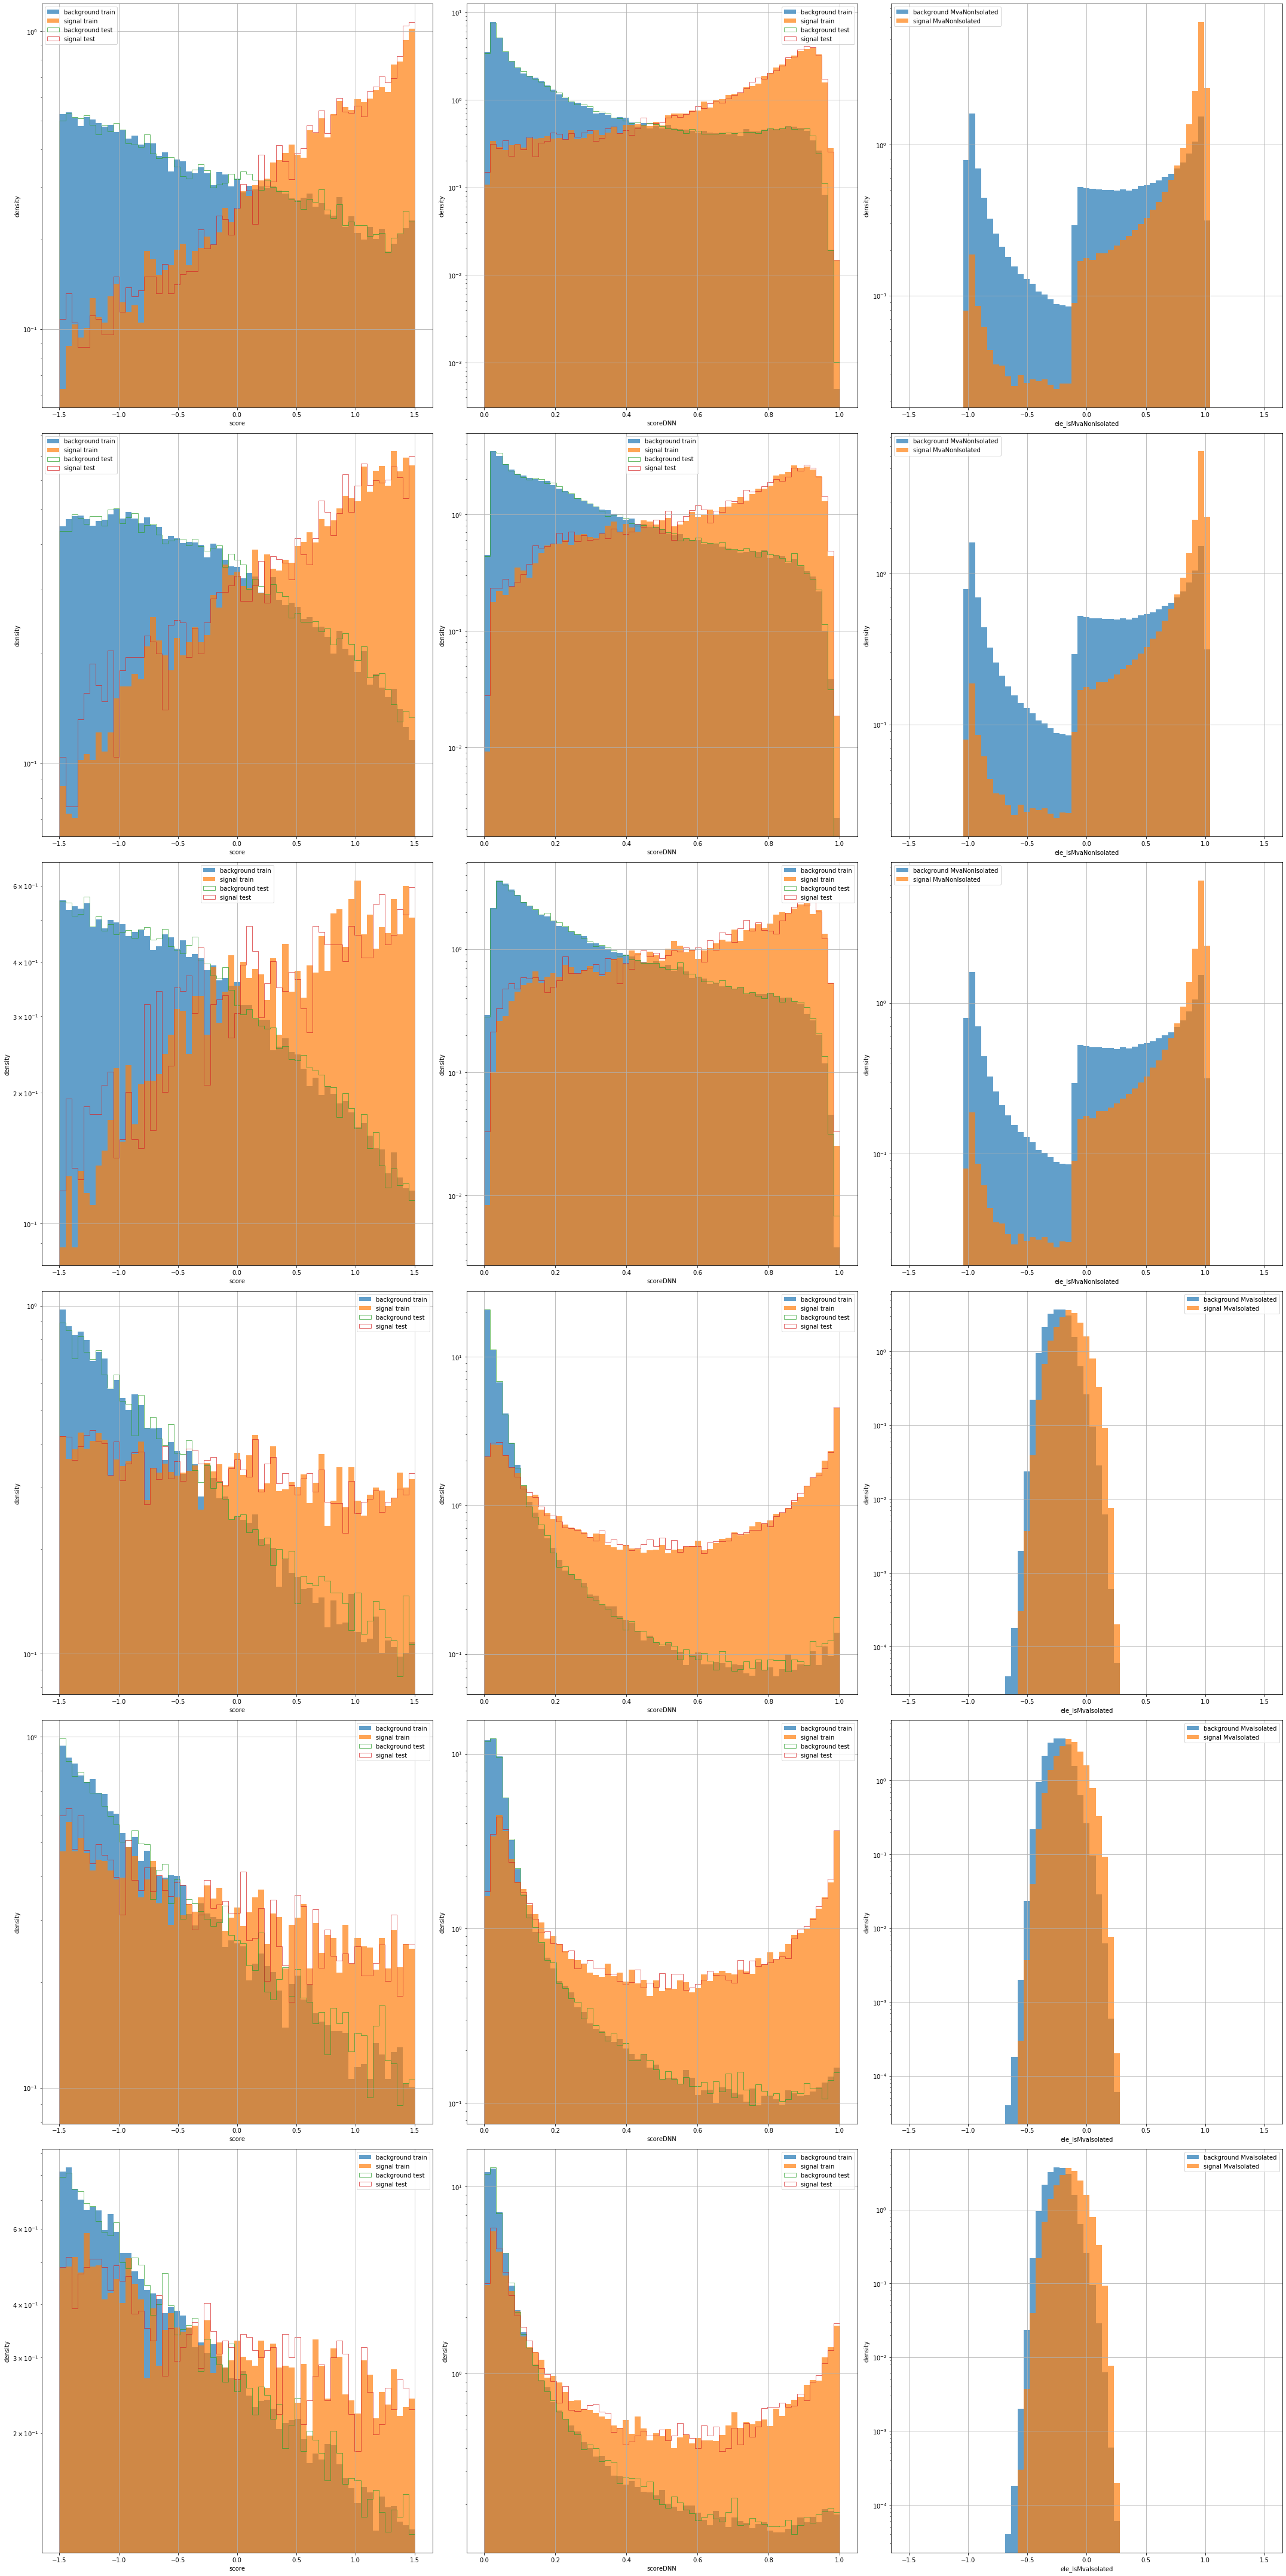

In [13]:
df_0vs3 = dfcomb.query("matchedToGenEle != 1")

plot_FinalROCsandMVAs(df_0vs3,catsplit,"XGB DNN WP","ROC MVA")

0
EB1_5
-0.1
auc_test=0.918438350836176
auc_train=0.9226592843770768
auc_testDNN=0.9233356113463465
auc_trainDNN=0.9228375730760814
auc_mvanoniso=0.8616161632461827
1
EB2_5
-0.1
auc_test=0.8881523673299658
auc_train=0.8999949899026849
auc_testDNN=0.8957217395281956
auc_trainDNN=0.8998979152041765
auc_mvanoniso=0.8238346146865366
2
EE_5
-0.1
auc_test=0.8863497085933013
auc_train=0.8999487950140926
auc_testDNN=0.891412299471616
auc_trainDNN=0.8957400311276317
auc_mvanoniso=0.7399435771053207
3
EB1_10
-0.1875
auc_test=0.9896062186107305
auc_train=0.9908547056711239
auc_testDNN=0.9917364051916804
auc_trainDNN=0.9926210929941304
auc_mvaiso=0.9651597562426747
4
EB2_10
-0.1875
auc_test=0.9846681769855905
auc_train=0.9851005939123766
auc_testDNN=0.9879535706920382
auc_trainDNN=0.9877381483197752
auc_mvaiso=0.9537482339575676
5
EE_10
-0.1075
auc_test=0.9696328935726005
auc_train=0.9710331888572878
auc_testDNN=0.9748139384844777
auc_trainDNN=0.9754168711212925
auc_mvaiso=0.9366832184059818


/usr/local/bin/start_ipykernel.py:90: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


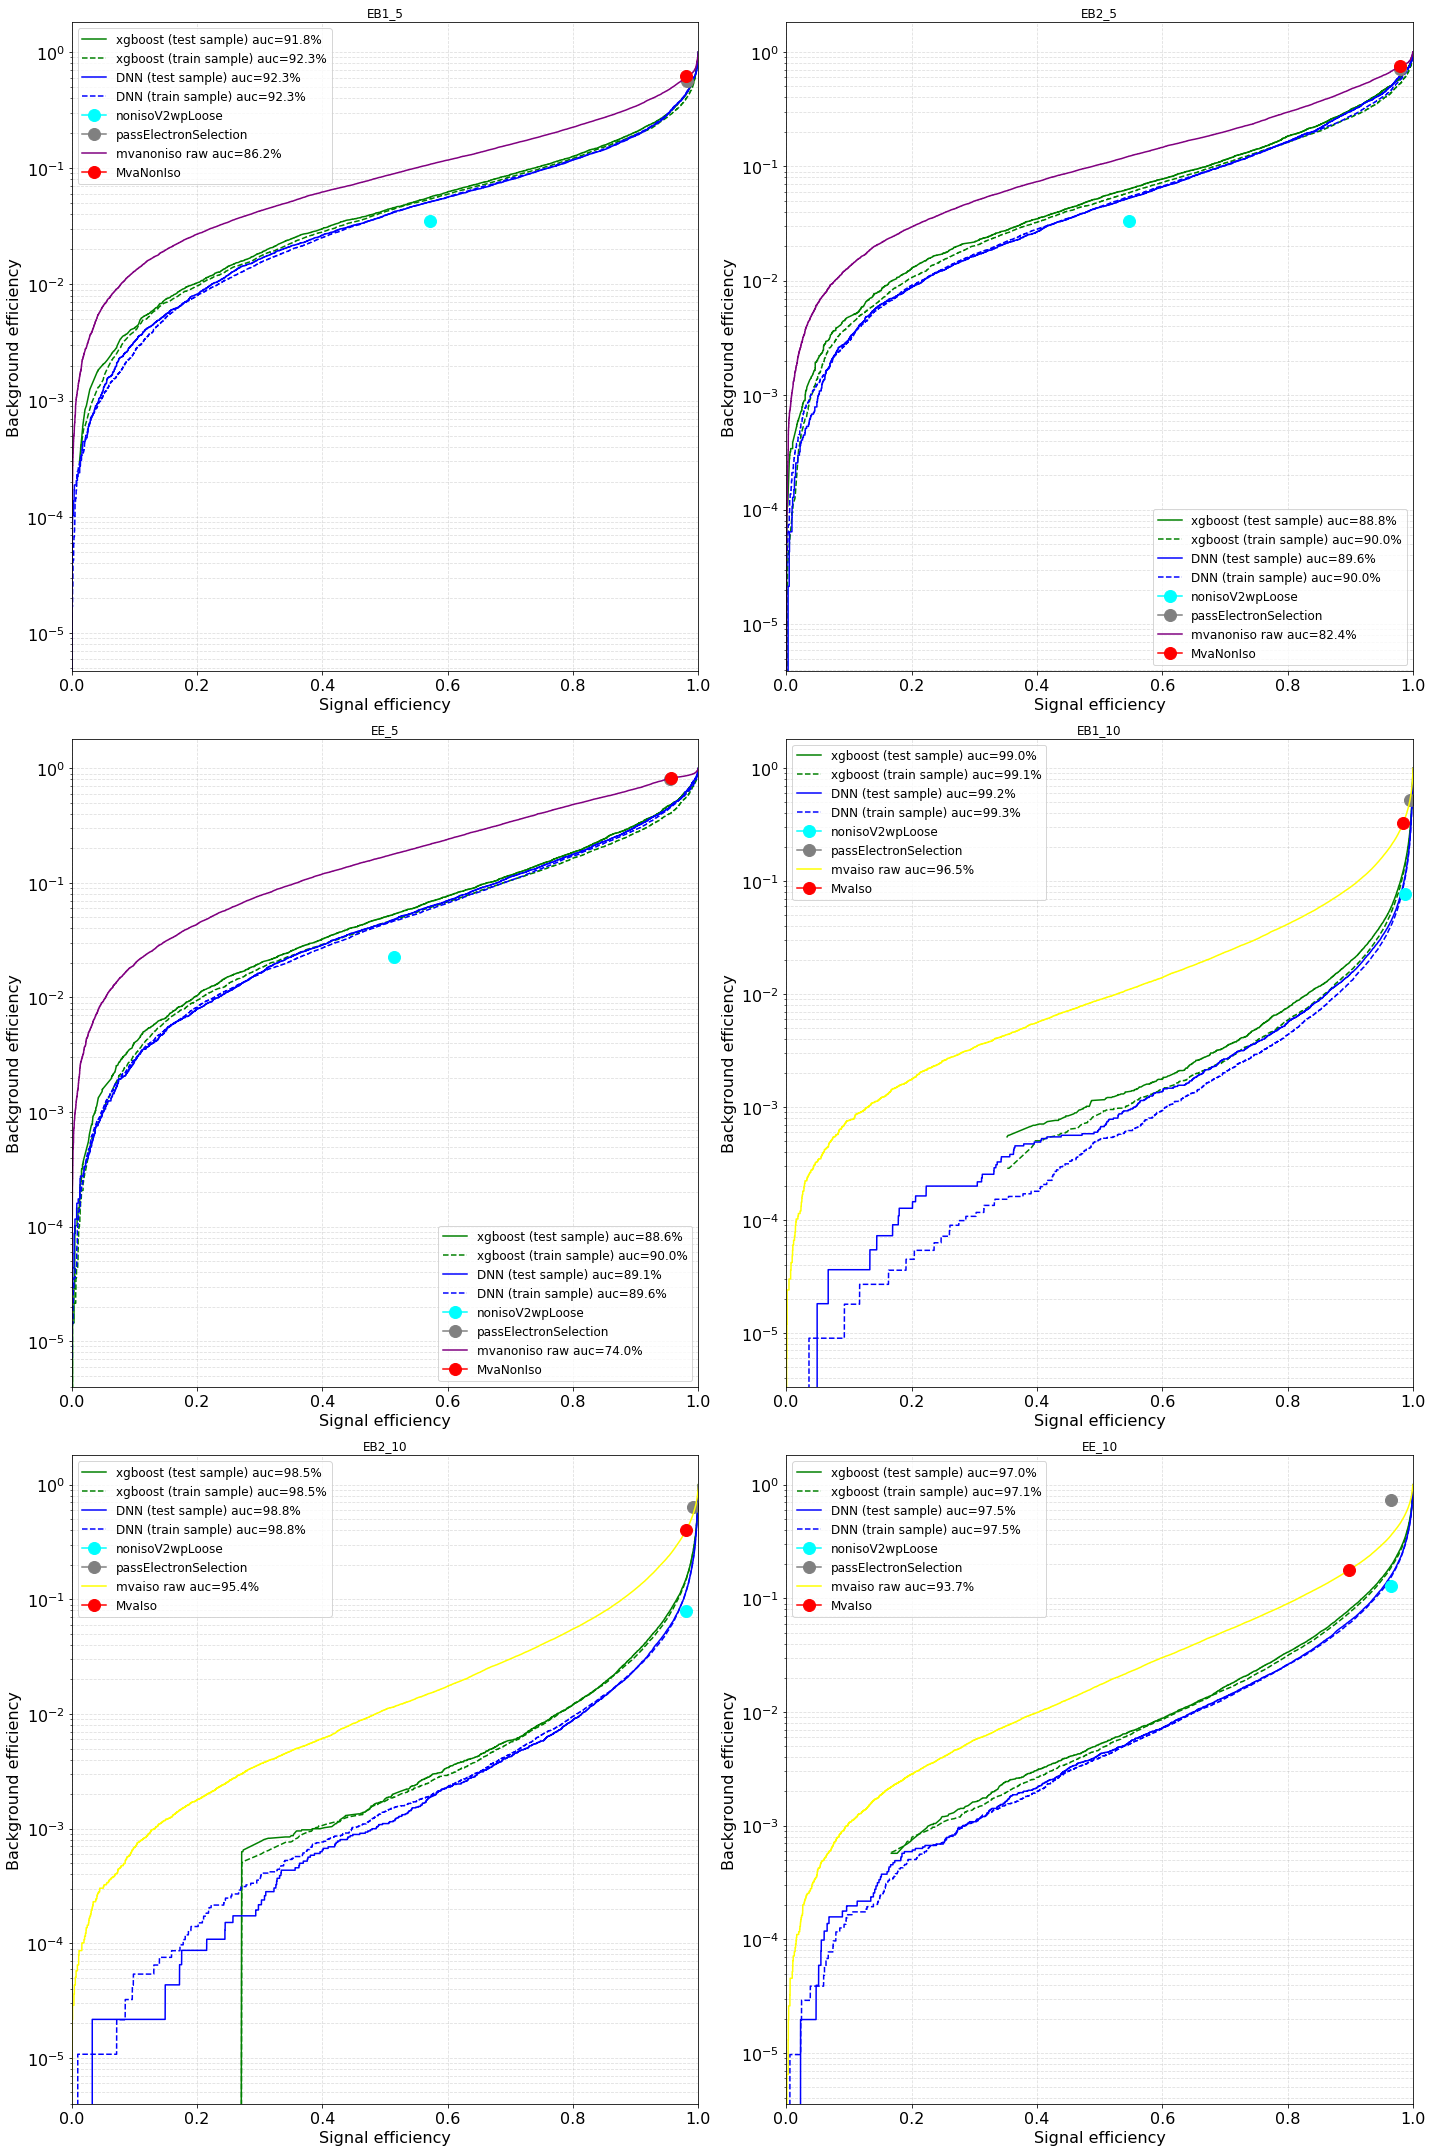

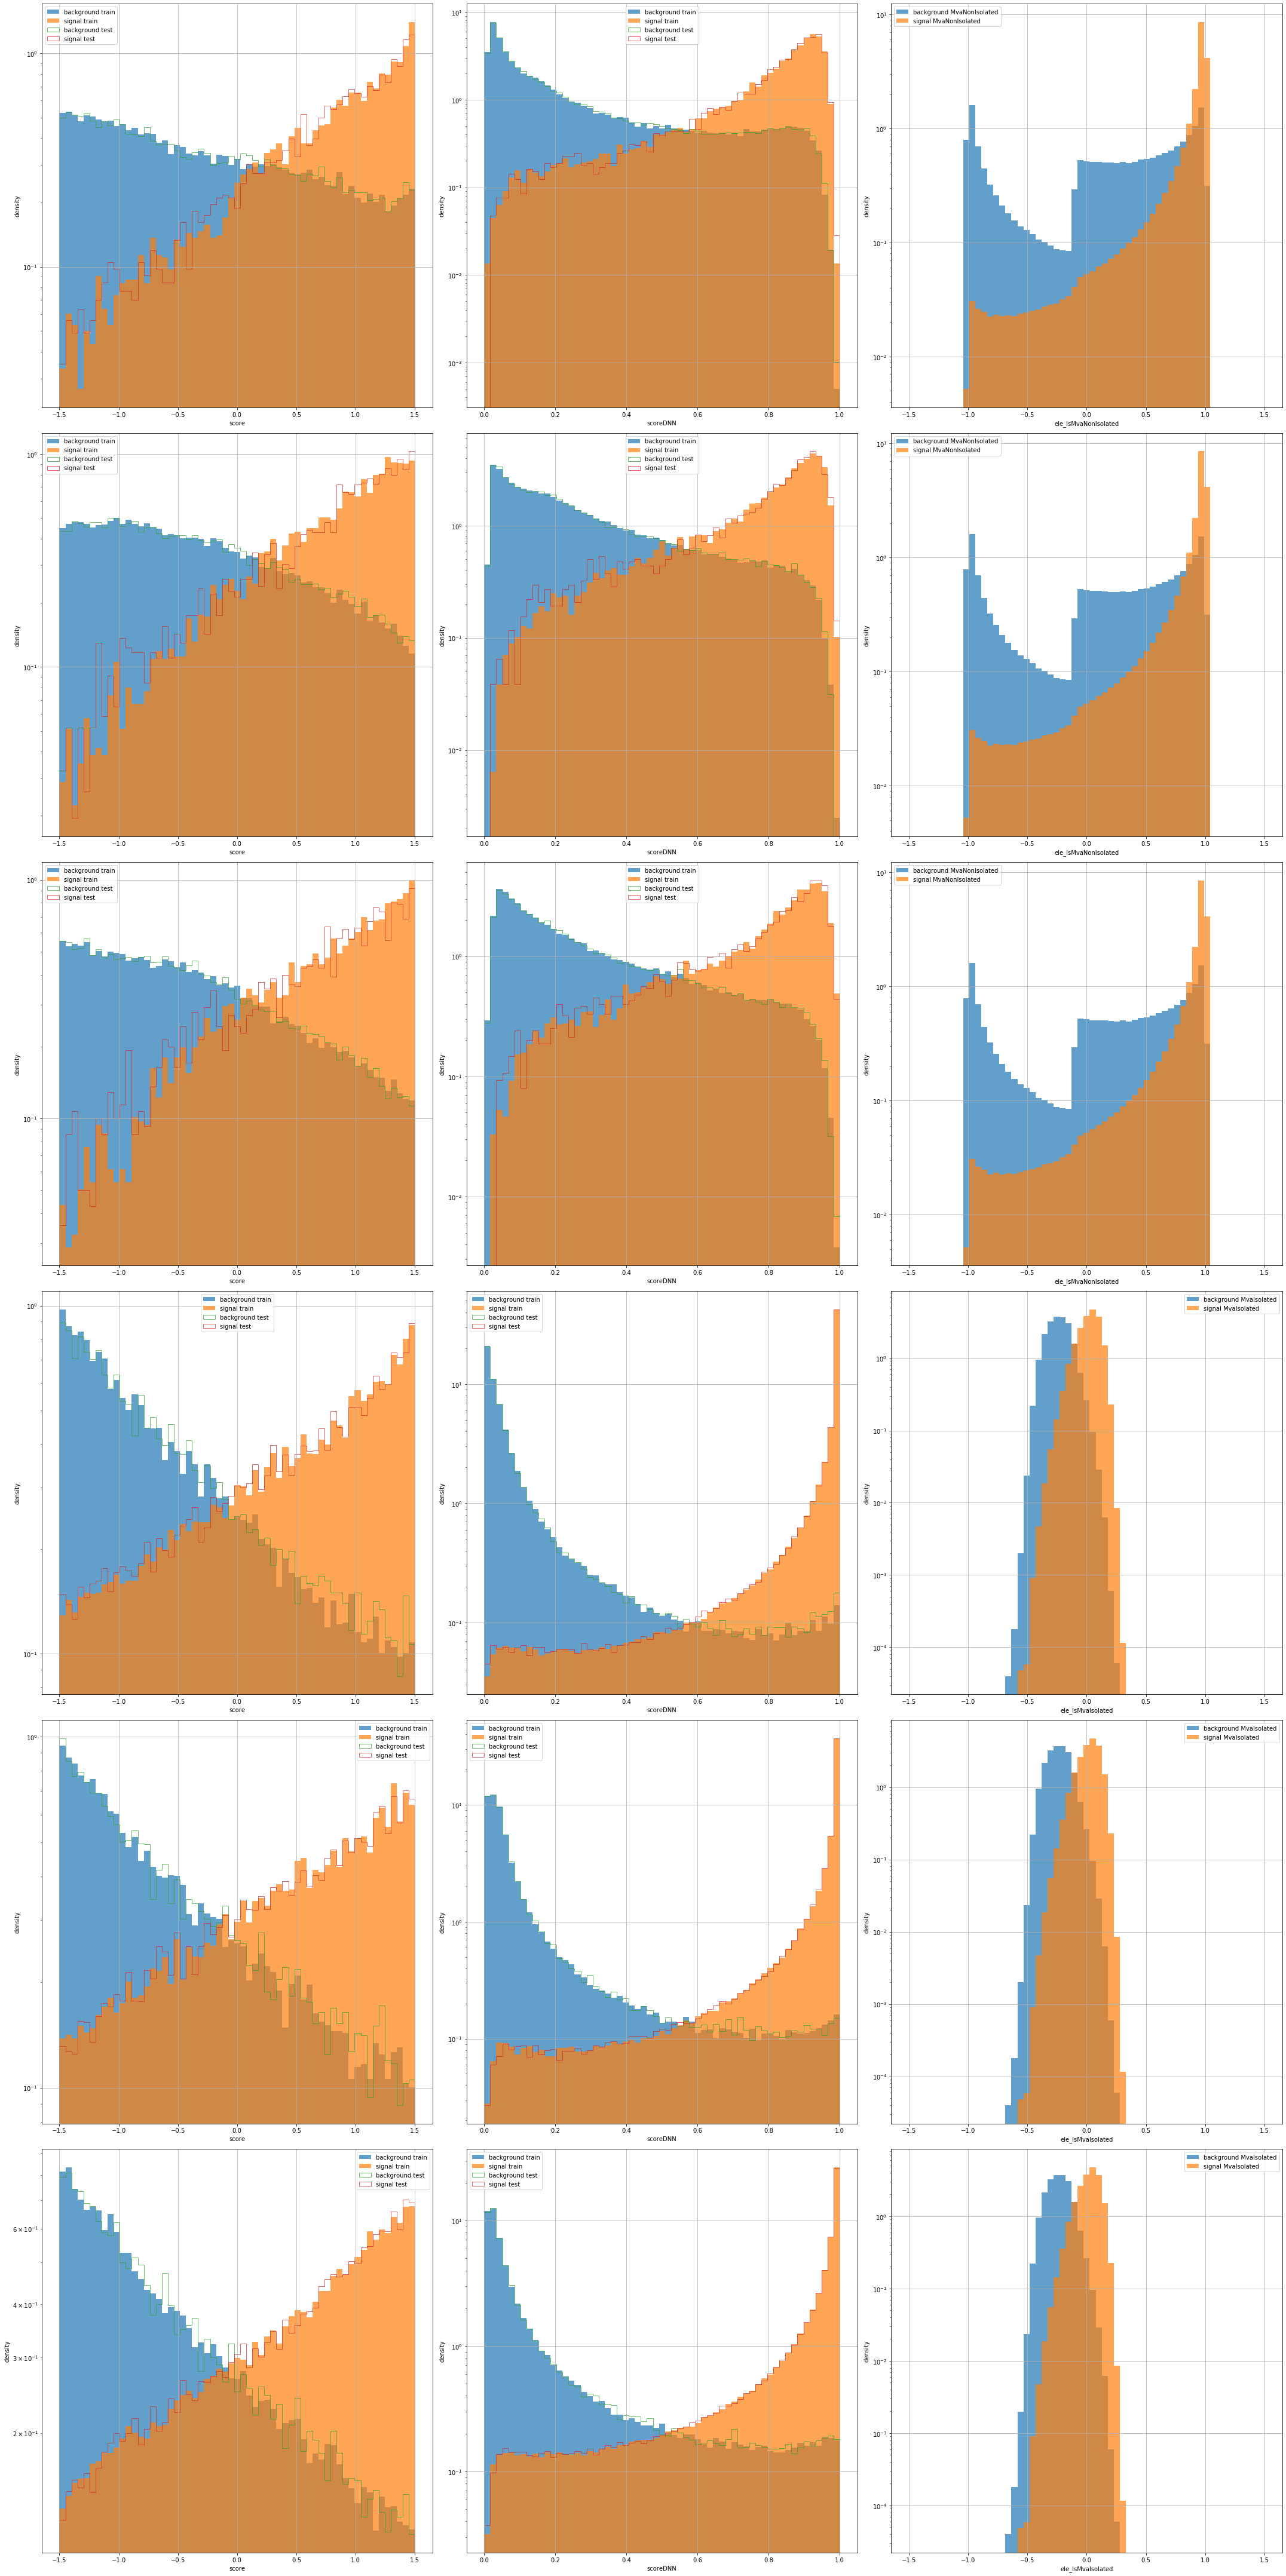

In [14]:
df_0vs1 = dfcomb.query("matchedToGenEle <2")

plot_FinalROCsandMVAs(df_0vs1,catsplit,"XGB DNN WP","ROC MVA")

In [15]:
df.columns

Index(['genNpu', 'vtxN', 'ele_q', 'ele_3q', 'ele_IsMvaIsolated',
       'ele_IsMvaNonIsolated', 'passElectronSelection', 'matchedToGenEle',
       'rho', 'ele_pt', 'ele_oldsigmaietaieta', 'ele_oldsigmaiphiiphi',
       'ele_oldcircularity', 'ele_oldr9', 'ele_scletawidth', 'ele_sclphiwidth',
       'ele_hadronicOverEm', 'ele_oldhe', 'ele_kfhits', 'ele_kfchi2',
       'ele_gsfchi2', 'ele_fbrem', 'ele_gsfhits', 'ele_expected_inner_hits',
       'ele_conversionVertexFitProbability', 'ele_ep', 'ele_eelepout',
       'ele_IoEmIop', 'ele_deltaetain', 'ele_deltaphiin', 'ele_deltaetaseed',
       'ele_psEoverEraw', 'ele_pfPhotonIso', 'ele_pfChargedHadIso',
       'ele_pfNeutralHadIso', 'scl_E', 'scl_Et', 'scl_eta', 'scl_phi',
       'ele_sclRawE', 'ele_sclNclus', 'ele_olde15', 'ele_olde25max',
       'ele_olde55', 'ele_ecalE', 'ele_ecalErr', 'ele_trackErr', 'ele_combErr',
       'ele_PFcombErr', 'ele_pfSumPUIso', 'ele_SCfbrem', 'ele_eClass',
       'ele_nbrem', 'ele_oldhebc', 'ele_hebc', 'ele_c

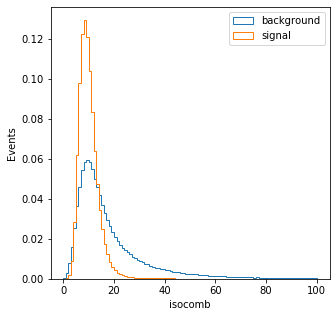

In [25]:
df['isocomb'] = df['ele_dr03TkSumPt'] + df['ele_dr03EcalRecHitSumEt'] + df['ele_dr03HcalTowerSumEt']
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plot_electrons(df, "isocomb", np.linspace(0, 100, 101), ax=axes,logscale=False)
#plot_electrons(df, "ele_dr03EcalRecHitSumEt", 100, ax=axes[0,1])
#plot_electrons(df, "ele_dr03HcalTowerSumEt", 100, ax=axes[0,2])

0
EB1_5
-0.1
auc_test=0.901167360424068
auc_train=0.914721860584676
auc_testDNN=0.9007999319124659
auc_trainDNN=0.9039614253664526
auc_mvanoniso=0.8447170969579867
1
EB2_5
-0.1
auc_test=0.8759629629578201
auc_train=0.897279036998201
auc_testDNN=0.8782543805189984
auc_trainDNN=0.8817809378596039
auc_mvanoniso=0.8216107696000161
2
EE_5
-0.1
auc_test=0.8819389025244044
auc_train=0.8983910471638618
auc_testDNN=0.8897981824097065
auc_trainDNN=0.8926615990468327
auc_mvanoniso=0.7621231651675635
3
EB1_10
-0.1875
auc_test=0.980821973984126
auc_train=0.9831945951184791
auc_testDNN=0.9839531711929372
auc_trainDNN=0.9852023459158581
auc_mvaiso=0.9275227065544247
4
EB2_10
-0.1875
auc_test=0.9673814766351447
auc_train=0.9715035147701027
auc_testDNN=0.9738969264113361
auc_trainDNN=0.976061874328711
auc_mvaiso=0.9120758999059481
5
EE_10
-0.1075
auc_test=0.9563740806528049
auc_train=0.9573680284434496
auc_testDNN=0.9632598322586042
auc_trainDNN=0.9628581005156568
auc_mvaiso=0.9097289360269828


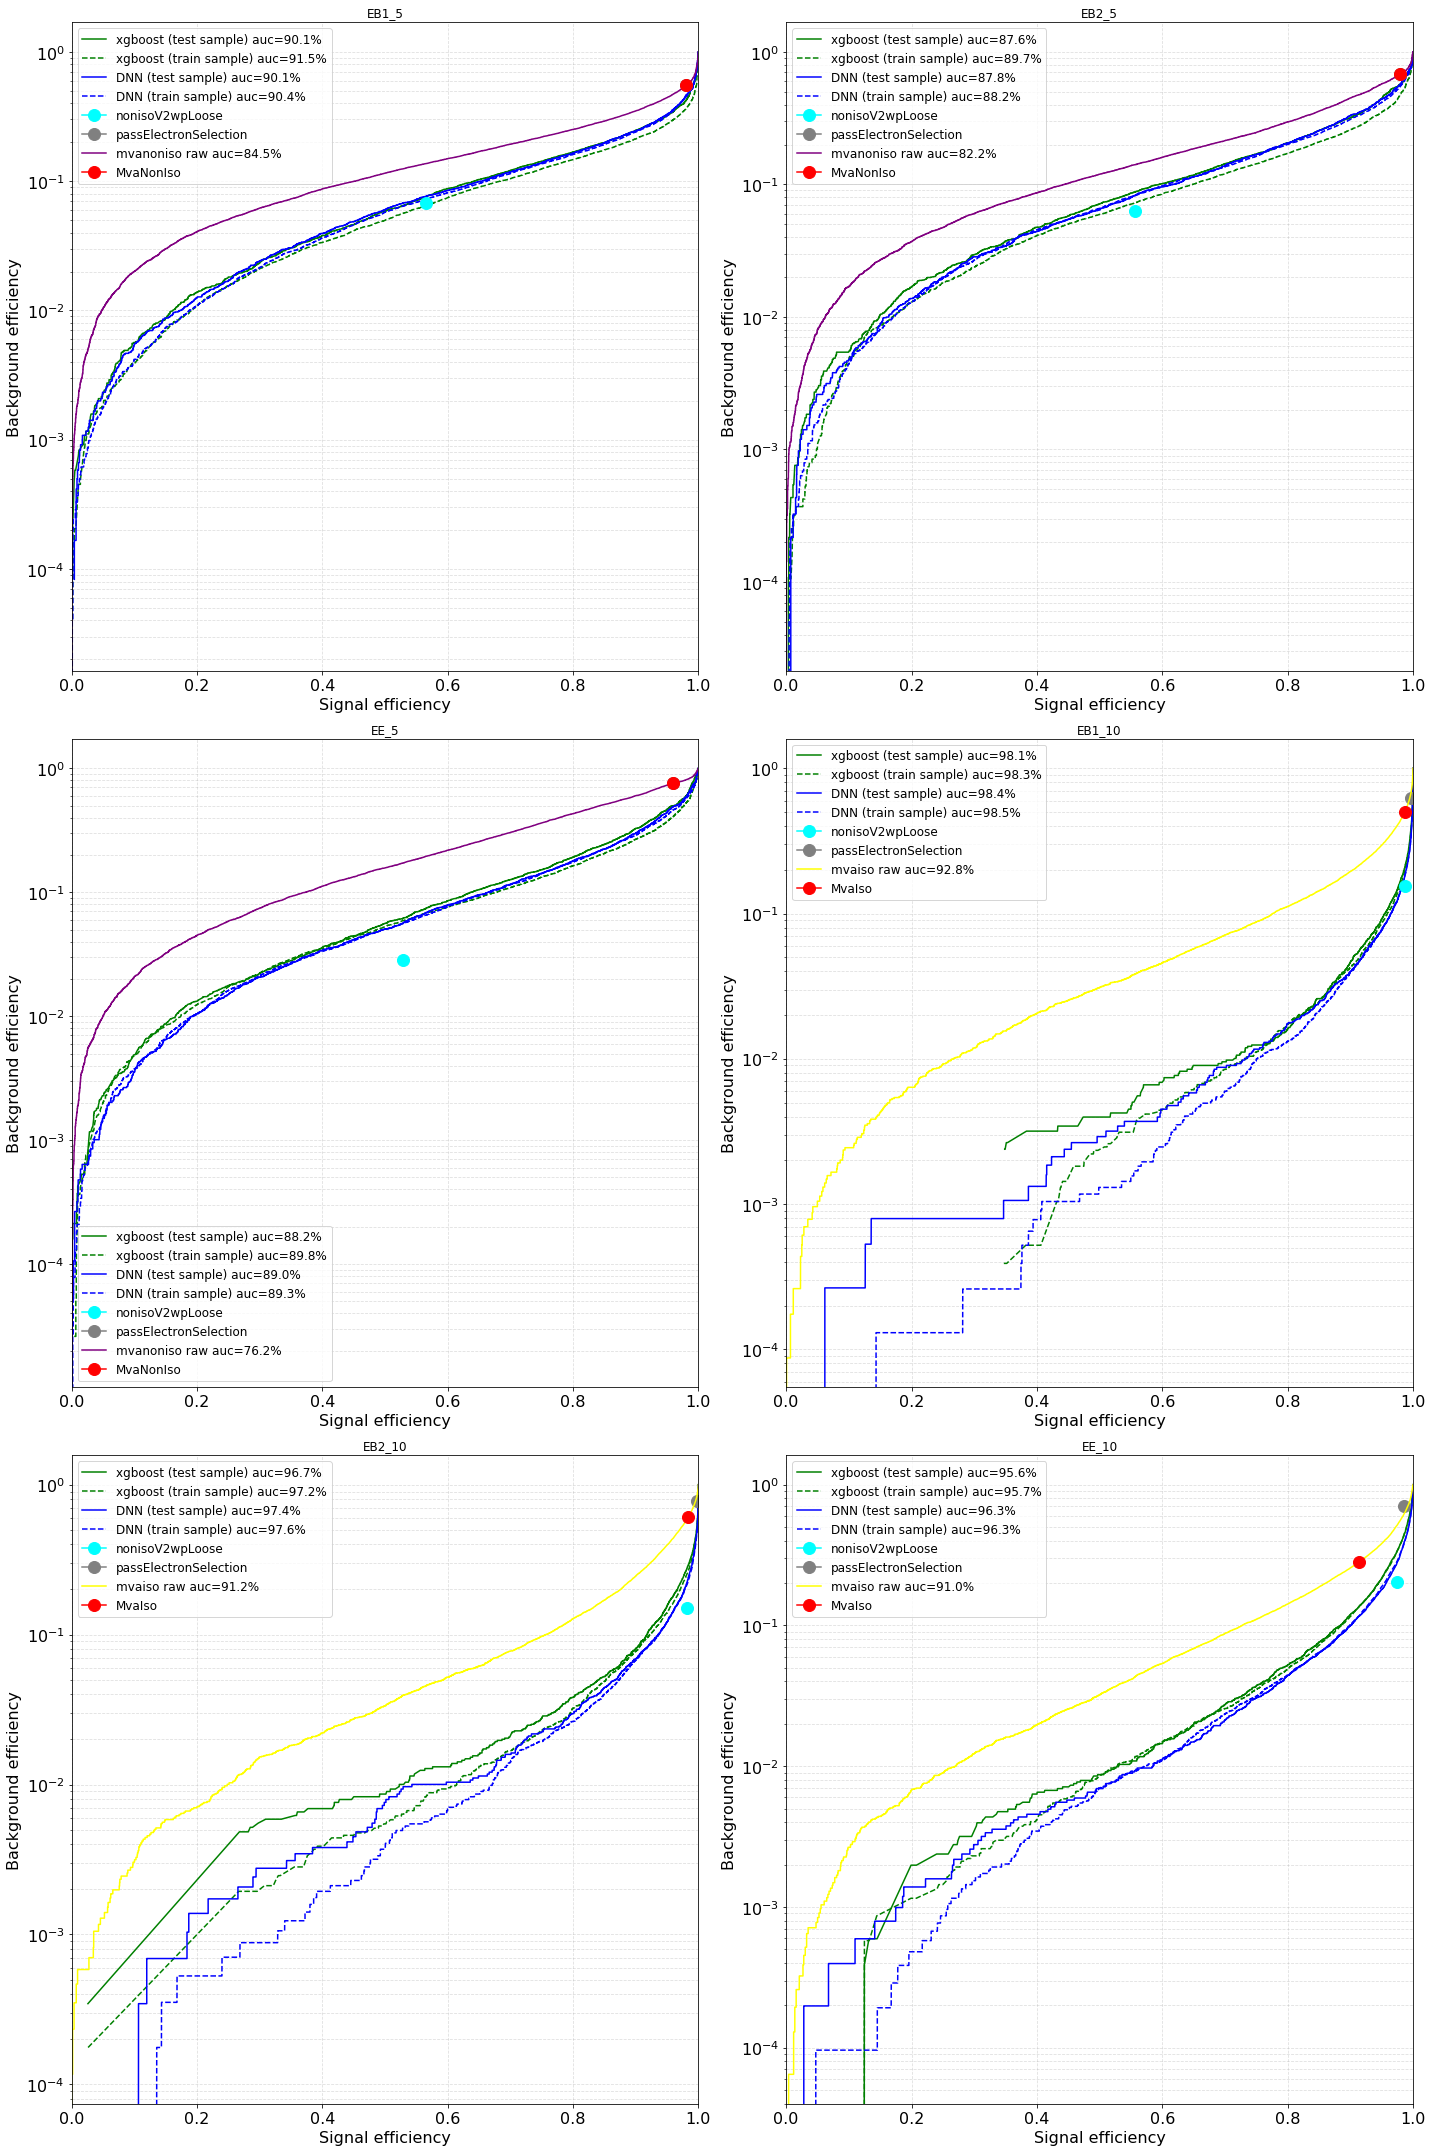

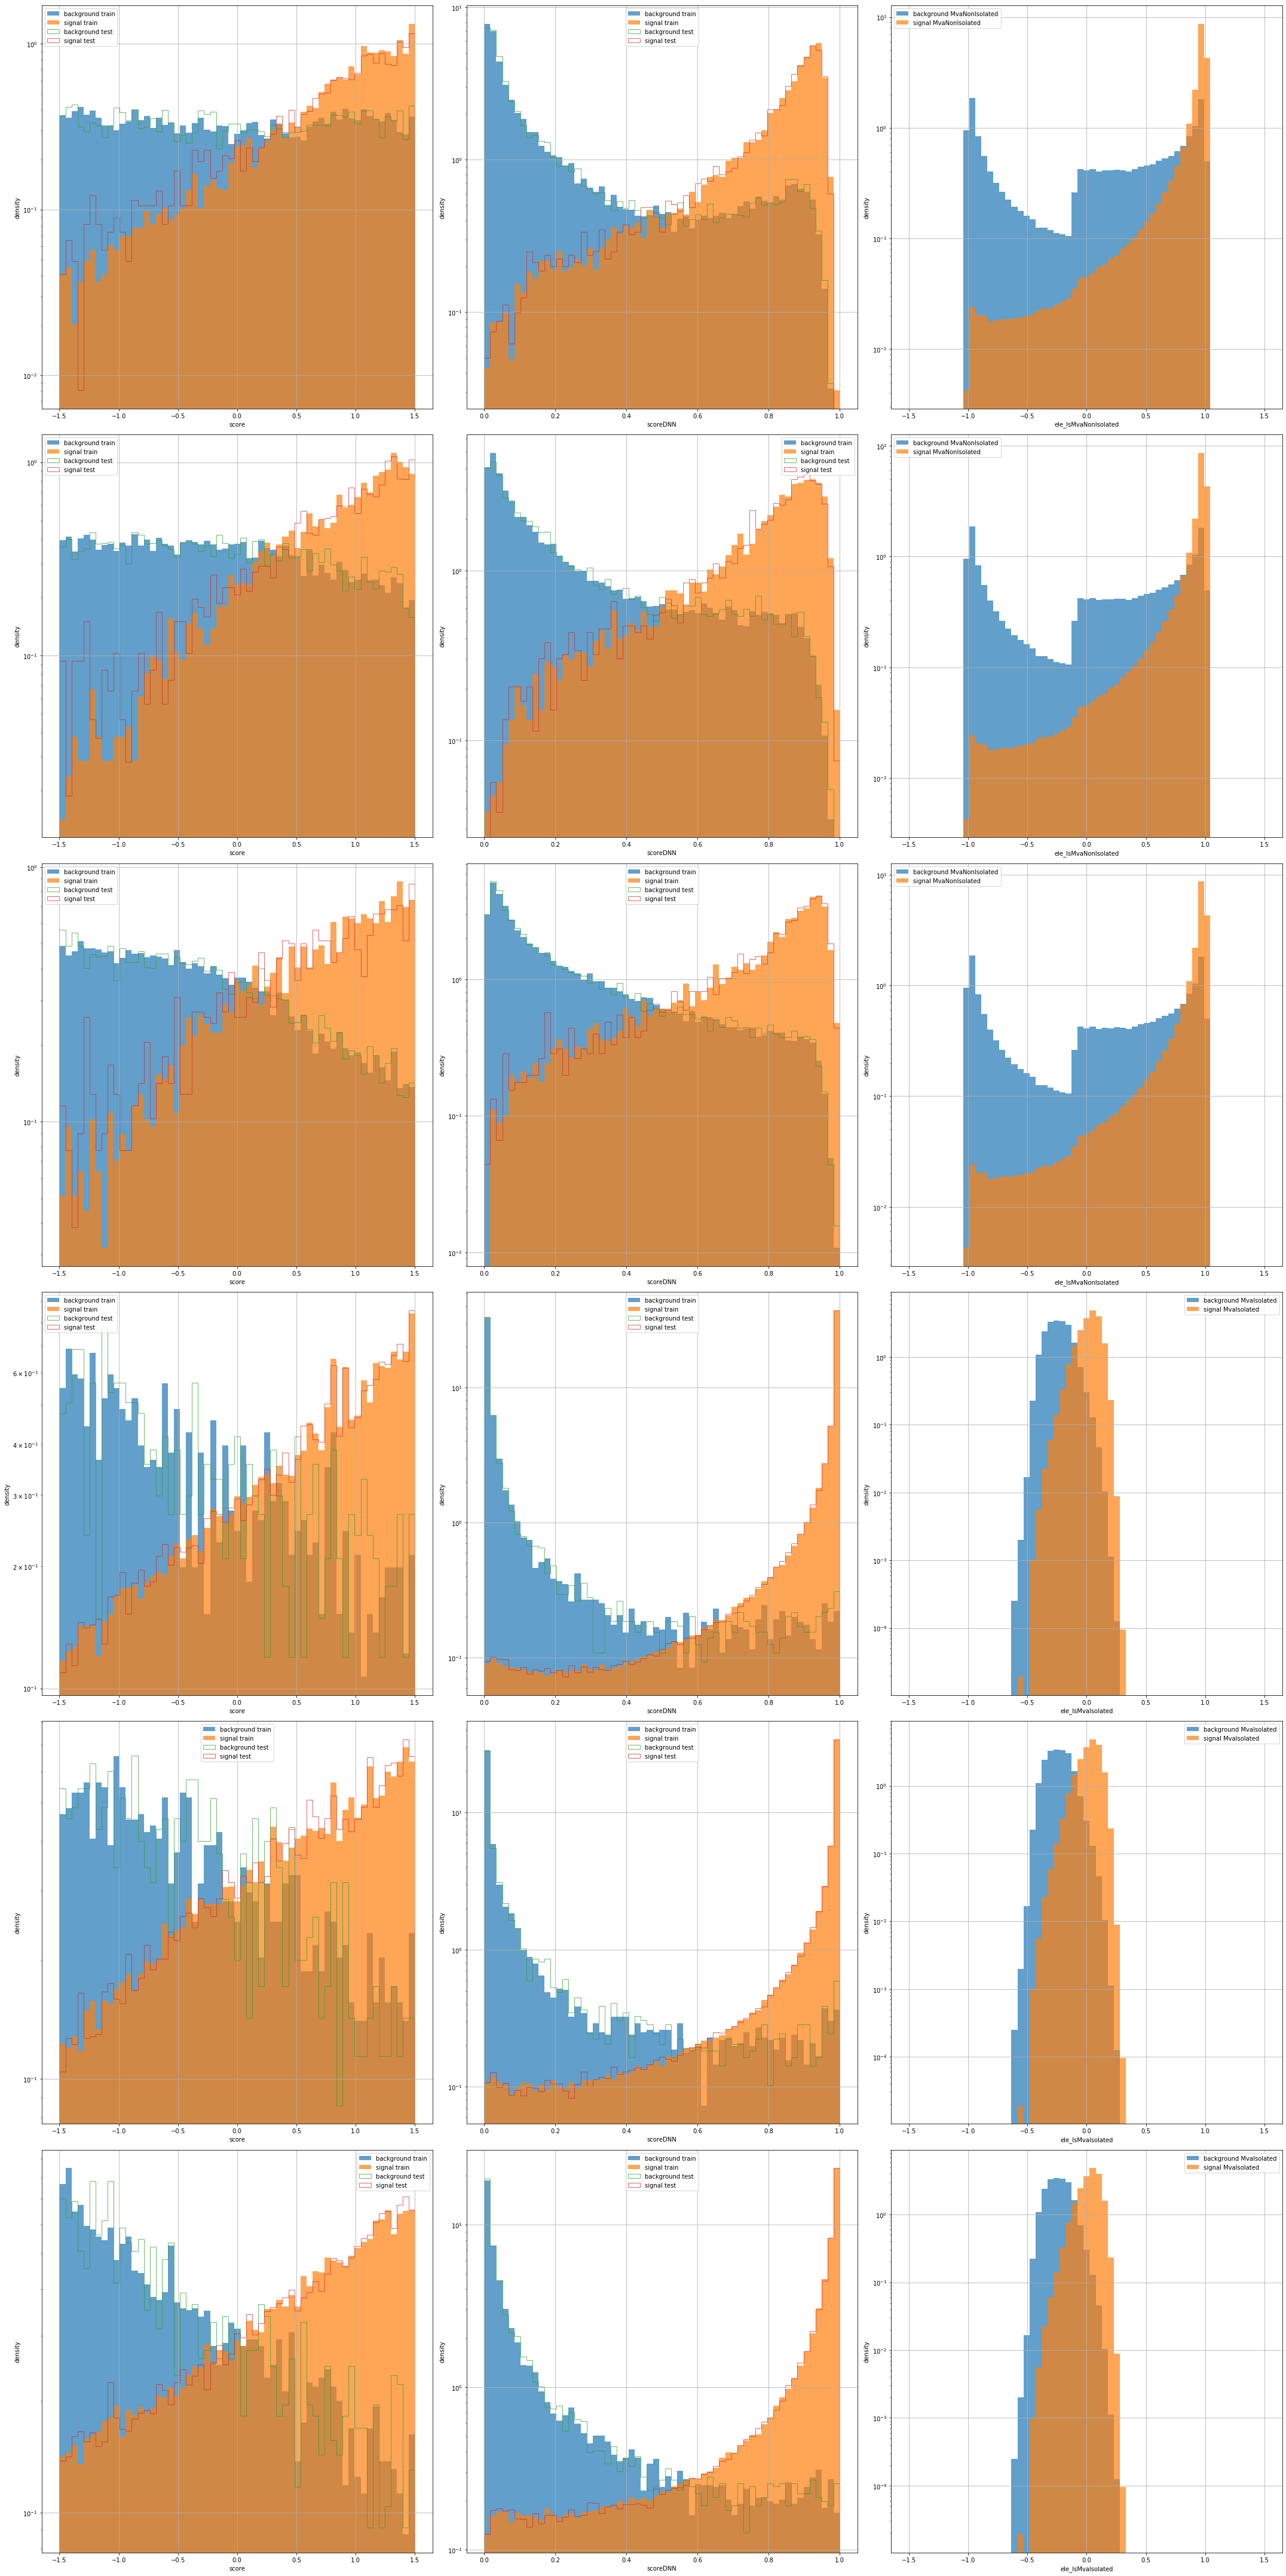

In [27]:
df_iso = df.query("isocomb<10")

plot_FinalROCsandMVAs(df_iso,catsplit,"XGB DNN WP","ROC MVA")

## 